# 🧊 Fridge Analyzer & Recipe Builder — Gemini + SAM + Hand Scale

**What this notebook does:**  
This is an end-to-end **Recipe Builder App** pipeline. It takes a single fridge photo with your hand in frame, uses your hand as a physical scale reference, runs **SAM** to segment individual items, auto-labels each segment with **Gemini 2.0 Flash**, and then calls **your tuned Gemini endpoint** to regress **volume (in³)** and **weight (lb)** for each detected item. Finally, it aggregates everything into a **fridge inventory** and asks Gemini to generate **recipe ideas** that respect the estimated quantities.

**Core flow:**

1. **Hand-as-Scale Calibration**  
   - Detects hand landmarks with MediaPipe.  
   - Uses your real hand length (inches) to compute **inches per pixel**.

2. **Segmentation & Labeling**  
   - Runs **SAM** to segment the fridge image into item crops.  
   - Calls **Gemini 2.0 Flash** to predict a semantic label and packaging flag for each crop (e.g., “loose tomato”, “yogurt tub”, “jar of pickles”).

3. **Numeric Volume & Weight Estimation**  
   - Converts bounding boxes into real-world dimensions (width/height in inches).  
   - Sends each crop + label + dimensions to **your tuned Gemini model** (Vertex AI Endpoint) which returns **volume_in3** and **weight_lb** via function calling.

4. **Inventory & Recipe Generation**  
   - Builds an **item-level inventory** by grouping segments with the same label and summing their estimated weights.  
   - Feeds this inventory to **Gemini** to generate a small set of **recipes** using those ingredients plus simple pantry staples.

---

**Why it’s robust:**

- Pins tricky dependencies (SAM, OpenCV, MediaPipe, etc.) to avoid ABI and import issues.  
- Sends images to Gemini as raw bytes with explicit MIME types to keep the Generative API happy.  
- Includes retry, timeout, and error-handling logic around the tuned endpoint calls.  
- Verifies that responses actually come from the **tuned model endpoint**, not a default `gemini-2.5-flash@default` base model.  
- Uses defensive parsing for function-call outputs and falls back to looser extraction if the model returns slightly dirty JSON.

---

**How to use:**

1. In the **Config** cell, fill in:
   - Your **Vertex Endpoint ID** for the tuned numeric model.  
   - Any project/region settings if not auto-detected.

2. Upload a **fridge photo** with your hand clearly visible in the frame.  

3. (Optional) If auto-labels are off for certain crops, add entries to `LABEL_OVERRIDES` for known segment IDs.

4. Run the notebook top-to-bottom to:
   - Calibrate the scale  
   - Segment and label items  
   - Estimate volume and weight  
   - Build inventory and generate recipes

---

**Outputs:**

- `/content/outputs/results.csv`  
  - Per-segment structured predictions (label, packaged flag, width/height in, volume_in3, weight_lb).

- `/content/outputs/inventory.csv`  
  - Aggregated fridge inventory (one row per ingredient with total estimated quantity).

- `/content/outputs/annotated_segments.jpg`  
  - Annotated segmentation view with bounding boxes and labels.

- `/content/outputs/hand_scale_debug.jpg`  
  - Hand detection and measurement overlay for sanity checking scale.

- Notebook cells with **Markdown recipes** generated from the current fridge inventory, ready to copy into a note or app.


# 1) Environment Setup (Clean Install + Version Verification)

This section prepares a **fully controlled, conflict-free environment** for running the Fridge Estimator pipeline in Google Colab.  
Because Colab ships with many preinstalled packages that can conflict with MediaPipe, OpenCV, NumPy, and Vertex AI SDKs.

## 1.1 — Environment Cleanup & Package Installation (Auto-Restarts Runtime)

### Purpose
This cell resets the Colab environment by removing conflicting preinstalled libraries and replacing them with **pinned, fully compatible versions** required for the Fridge Estimator pipeline.  
It ensures a clean, stable foundation for computer vision, MediaPipe, and Vertex AI operations.

### What this cell does
- **Uninstalls** potentially conflicting system packages, including:  
  NumPy, MediaPipe, OpenCV, Protobuf, Google Auth libraries, `google-cloud-aiplatform`, and `vertexai`.
- **Installs** your exact pinned versions for all core components.
- **Prevents ABI and import errors** by aligning NumPy ↔ OpenCV ↔ MediaPipe ↔ Protobuf compatibility.
- **Ensures Google SDK stability** so the Vertex AI and Generative AI APIs work as expected.
- **🔁 Automatically restarts the runtime** after installation  
  (required for OpenCV, MediaPipe, and Protobuf to load cleanly in memory).

After the restart, continue with the next cell to import and verify the installed versions.


In [2]:
# ============================
# 1.1  Main Install Cell
# ============================

import subprocess, IPython, sys

def sh(cmd):
    print("➜", cmd)
    return subprocess.run(cmd, shell=True, check=False)

# -------------------------------
# Check Python version
# -------------------------------
py_ver = f"{sys.version_info.major}.{sys.version_info.minor}"
if py_ver not in ("3.10","3.11"):
    print(f"⚠️ Switch Colab runtime to Python 3.11 or 3.10 → Runtime > Change runtime type.")
else:
    print("📦 Cleaning environment and installing pinned versions...")

    # -------------------------------
    # 0. Remove conflicting packages
    # -------------------------------
    sh('pip -q uninstall -y mediapipe numpy opencv-python opencv-contrib-python '
       'opencv-python-headless protobuf google-cloud-aiplatform vertexai '
       'googleapis-common-protos google-api-core google-auth >/dev/null 2>&1')

    # -------------------------------
    # 1. Core Pins
    # -------------------------------
    sh('pip -q install --no-cache-dir --upgrade --force-reinstall '
       '"numpy==1.26.4" "protobuf==4.25.3"')

    # -------------------------------
    # 2. Vision + Utils
    # -------------------------------
    sh('pip -q install --no-cache-dir --upgrade --force-reinstall '
       '"mediapipe==0.10.21" "opencv-python==4.9.0.80" '
       '"pillow==10.3.0" "matplotlib==3.8.4" "pandas==2.2.2" "tqdm==4.67.1"')

    # -------------------------------
    # 3. Google Client Libraries
    # -------------------------------
    sh('pip -q install --no-cache-dir --upgrade --force-reinstall '
       '"google-auth==2.38.0" "googleapis-common-protos==1.63.0" "google-api-core==2.19.1"')

    # -------------------------------
    # 4. Vertex AI SDKs
    # -------------------------------
    sh('pip -q install --no-cache-dir --upgrade --force-reinstall '
       '"google-cloud-aiplatform==1.63.0" "vertexai==1.63.0"')

    # -------------------------------
    # 5. OCR + Barcode Dependencies
    # -------------------------------
    print("\n🔤 Installing OCR + Barcode dependencies…")

    # Tesseract OCR system package
    sh("apt-get update")
    sh("apt-get install -y tesseract-ocr")

    # pytesseract Python binding
    sh("pip install pytesseract")

    # ZBar library for barcode decoding
    sh("apt-get update -y")
    sh("apt-get install -y libzbar0")

    # pyzbar, EasyOCR, requests
    sh("pip install pyzbar easyocr requests")

    print("\n🔁 Restarting runtime to finalize installs…")
    IPython.Application.instance().kernel.do_shutdown(restart=True)


📦 Cleaning environment and installing pinned versions...
➜ pip -q uninstall -y mediapipe numpy opencv-python opencv-contrib-python opencv-python-headless protobuf google-cloud-aiplatform vertexai googleapis-common-protos google-api-core google-auth >/dev/null 2>&1
➜ pip -q install --no-cache-dir --upgrade --force-reinstall "numpy==1.26.4" "protobuf==4.25.3"
➜ pip -q install --no-cache-dir --upgrade --force-reinstall "mediapipe==0.10.21" "opencv-python==4.9.0.80" "pillow==10.3.0" "matplotlib==3.8.4" "pandas==2.2.2" "tqdm==4.67.1"
➜ pip -q install --no-cache-dir --upgrade --force-reinstall "google-auth==2.38.0" "googleapis-common-protos==1.63.0" "google-api-core==2.19.1"
➜ pip -q install --no-cache-dir --upgrade --force-reinstall "google-cloud-aiplatform==1.63.0" "vertexai==1.63.0"

🔤 Installing OCR + Barcode dependencies…
➜ apt-get update
➜ apt-get install -y tesseract-ocr
➜ pip install pytesseract
➜ apt-get update -y
➜ apt-get install -y libzbar0
➜ pip install pyzbar easyocr requests



## 1.2 — Import Libraries & Verify Installed Versions

### Purpose
After the runtime restart triggered in the previous step, this cell re-imports all essential libraries and confirms that the correct pinned versions were successfully installed.

### What this cell does
- **Imports** NumPy, OpenCV, MediaPipe, Pandas  
- **Loads** Google Cloud client libraries (`aiplatform`, `vertexai`)
- **Prints the exact installed versions** to verify compatibility
- **Confirms completion** of the environment setup with a success message

### Expected Output
You should see version numbers matching your pins, for example:



In [1]:
# ============================
# 1.2  Environment Check Cell
# ============================

import numpy, cv2, mediapipe as mp, pandas as pd
import google.cloud.aiplatform as aiplatform, vertexai

# OCR libs
import pytesseract
import easyocr

# Barcode
from pyzbar import pyzbar

print("NumPy:", numpy.__version__)
print("OpenCV:", cv2.__version__)
print("MediaPipe:", mp.__version__)
print("Pandas:", pd.__version__)
print("aiplatform:", aiplatform.__version__)
print("vertexai:", vertexai.__version__)

print("pytesseract:", pytesseract.__version__)
print("EasyOCR: OK (module loaded)")
print("pyzbar: OK (module loaded)")

print("\n✅ Environment ready!")


/usr/local/lib/python3.11/dist-packages/jaxlib/plugin_support.py:71: RuntimeWarning: JAX plugin jax_cuda12_plugin version 0.5.1 is installed, but it is not compatible with the installed jaxlib version 0.7.1, so it will not be used.
  warnings.warn(


NumPy: 2.2.6
OpenCV: 4.12.0
MediaPipe: 0.10.21
Pandas: 2.2.2
aiplatform: 1.63.0
vertexai: 1.63.0
pytesseract: 0.3.13
EasyOCR: OK (module loaded)
pyzbar: OK (module loaded)

✅ Environment ready!


# 2) Vertex AI Setup (Authentication + Tuned Model Configuration)

This section prepares your Colab environment to communicate with **Vertex AI** and your **tuned Gemini model**.  

## 2.1 — Vertex AI Authentication & Initialization

This step authenticates your Colab session with Google Cloud and initializes both the **Vertex AI** and **Generative AI** SDKs.  
We explicitly set the active **GCP Project** and **Region** so all future Gemini, tuning, and image-processing calls execute in **`us-central1`**, the primary region for Vertex Generative AI.

To keep the workflow clean and composable, we expose two key configuration variables:

- **`PROJECT_ID`** — your active Google Cloud project  
- **`LOCATION`** — the region for all Vertex AI requests  
- **`EP_TUNED_ID`** — the endpoint hosting your tuned Gemini model

These variables make it easy to reuse the same configuration across notebook sections without re-authenticating or reinitializing.


In [2]:
from google.colab import auth as colab_auth
from google.cloud import aiplatform
import vertexai

# 1. Authenticate the Colab user for GCP access
colab_auth.authenticate_user()

# 2. Configuration (safe to keep visible — these are NOT secrets)
PROJECT_ID = "927828199877"   # Your GCP project ID
LOCATION   = "us-central1"    # Recommended region for Gemini/Vertex

# 3. Initialize both SDKs
vertexai.init(project=PROJECT_ID, location=LOCATION)
aiplatform.init(project=PROJECT_ID, location=LOCATION)

print("✅ Vertex AI initialized →", PROJECT_ID, LOCATION)


✅ Vertex AI initialized → 927828199877 us-central1


## 2.2 — Tuned Endpoint & Labeling Behavior Configuration

This cell configures **how** we talk to your tuned Gemini model and **how** it behaves when labeling fridge crops.

### What you configure here

- **`EP_TUNED_ID`**  
  The **Endpoint ID** of your tuned Gemini deployment.  
  You can copy this from the Vertex AI Console under  
  *Vertex AI → Endpoints → your tuned endpoint*.

- **Routing flags**
  - `USING_GENERATIVE_SDK = True`  
    Always use the Generative API surface for Gemini.
  - `USE_DEPLOYED_ENDPOINT = True`  
    Route tuned inference to your deployed endpoint’s `:generateContent` method.

- **Generation behavior**
  - `GEN_MAX_TOKENS` — maximum tokens for tuned model responses  
    (we default to **1024**, matching your tuning setup).

- **Auto-label configuration**
  - `ENABLE_AUTO_LABEL` — toggles Gemini auto-labeling for detected crops, useful when you don’t pass manual `LABEL_OVERRIDES`.
  - `ALLOWED_LABELS` — a curated whitelist of food/container categories the labeler is allowed to emit.
  - `LABEL_OVERRIDES` — optional manual mapping from crop index → label, e.g. `{0: "banana", 3: "apple"}`.
  - `LABEL_DEFAULT` — fallback label if neither overrides nor auto-labeling yields a result.

### Networking setup

At the end, we:

- Obtain an authenticated `AuthorizedSession` using your current Colab credentials.
- Build the full tuned endpoint URL (`URL_TUNED`) targeting your project, region, and endpoint ID.
- Print the URL so you can quickly verify it matches the Vertex AI Console.


In [3]:
from google.auth.transport.requests import Request, AuthorizedSession
import google.auth, io, base64, json

# ---- Core tuned endpoint configuration ----
EP_TUNED_ID = "8041360753111859200"  # Vertex AI Endpoint ID for your tuned Gemini model
assert EP_TUNED_ID, "❌ EP_TUNED_ID is empty — please set your tuned endpoint ID from the Vertex Console."

USING_GENERATIVE_SDK = True      # Always use the Generative API for Gemini
USE_DEPLOYED_ENDPOINT = True     # Route tuned inference to endpoint :generateContent
GEN_MAX_TOKENS = 1024            # Output budget for the tuned model

# ---- Labeling behavior ----
ENABLE_AUTO_LABEL = True         # Use Gemini to auto-label crops when no manual overrides
ALLOWED_LABELS = [
    "apple","banana","orange","lemon","lime","grape","strawberry","blueberry",
    "tomato","cucumber","carrot","bell pepper","onion","garlic","ginger",
    "lettuce","spinach","broccoli","cauliflower","bread","egg carton","yogurt",
    "milk carton","juice bottle","soda can","water bottle","leftovers container",
    "cheese","butter","avocado","pear","peach","plum","kiwi",
]

# Optional manual overrides: {crop_index: "label"}
LABEL_OVERRIDES: dict[int, str] = {}  # e.g., {0: "banana", 3: "apple"}
LABEL_DEFAULT: str | None = None      # Fallback label if nothing else applies

# ---- Authenticated HTTP session for tuned endpoint ----
creds, _ = google.auth.default(scopes=["https://www.googleapis.com/auth/cloud-platform"])
if not creds.valid:
    creds.refresh(Request())
SESSION = AuthorizedSession(creds)

URL_TUNED = (
    f"https://{LOCATION}-aiplatform.googleapis.com/v1/"
    f"projects/{PROJECT_ID}/locations/{LOCATION}/endpoints/{EP_TUNED_ID}:generateContent"
)

print("🔗 Tuned endpoint URL:")
print("   ", URL_TUNED)


🔗 Tuned endpoint URL:
    https://us-central1-aiplatform.googleapis.com/v1/projects/927828199877/locations/us-central1/endpoints/8041360753111859200:generateContent


# 3) Upload Image & Hand-as-Scale Calibration

This step uploads a single fridge photo and estimates a **real-world scale** in inches per pixel using your hand as a reference.

We assume:
- Your hand is visible in the image.
- We measure the distance between **wrist (landmark 0)** and **middle finger tip (landmark 12)** using MediaPipe Hands.
- You provide your **actual hand length** (wrist → middle fingertip) in inches via `HAND_LENGTH_INCHES`.

The code:
- Prompts you to upload a fridge image.
- Saves it as `/content/fridge.jpg` for downstream steps.
- Runs MediaPipe Hands to find the two landmarks.
- Computes `INCHES_PER_PIXEL = HAND_LENGTH_INCHES / pixel_distance`.
- Draws the two landmarks and the measurement line for visual confirmation.


⬆️ Upload a single fridge image (with your hand visible for scale)…


Saving 1.jpeg to 1.jpeg
✅ Saved to: /content/fridge.jpg
📏 Hand pixels: 1430 → INCHES_PER_PIXEL = 0.005245


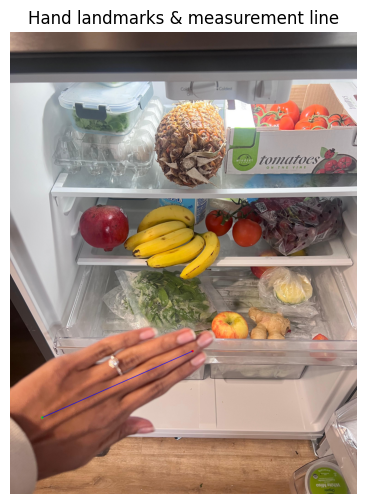

In [4]:
from google.colab import files
import os
import cv2, numpy as np, mediapipe as mp
import matplotlib.pyplot as plt

UPLOAD_PATH = "/content/fridge.jpg"

print("⬆️ Upload a single fridge image (with your hand visible for scale)…")
up = files.upload()
assert len(up) == 1, "Upload exactly one image."

src_name = list(up.keys())[0]
os.replace(src_name, UPLOAD_PATH)
print("✅ Saved to:", UPLOAD_PATH)

# 👉 Set your measured wrist→middle fingertip length (inches)
HAND_LENGTH_INCHES = 7.5  # ← adjust to your own hand measurement

def compute_inches_per_pixel(image_bgr, hand_length_inches: float):
    """Estimate inches per pixel using wrist(0) → middle finger tip(12)."""
    mp_hands = mp.solutions.hands
    with mp_hands.Hands(static_image_mode=True, max_num_hands=1) as hands:
        image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
        res = hands.process(image_rgb)
        if not res.multi_hand_landmarks:
            raise RuntimeError("No hand detected. Try a brighter photo, hand in-frame and near items.")
        lm = res.multi_hand_landmarks[0]

        wrist, midtip = lm.landmark[0], lm.landmark[12]
        h, w = image_bgr.shape[:2]
        x0, y0 = int(wrist.x * w), int(wrist.y * h)
        x1, y1 = int(midtip.x * w), int(midtip.y * h)

        pixel_dist = max(1, int(np.hypot(x1 - x0, y1 - y0)))
        inches_per_pixel = hand_length_inches / float(pixel_dist)

        vis = image_bgr.copy()
        cv2.circle(vis, (x0, y0), 10, (0, 255, 0), -1)   # wrist
        cv2.circle(vis, (x1, y1), 10, (0, 0, 255), -1)   # fingertip
        cv2.line(vis, (x0, y0), (x1, y1), (255, 0, 0), 4)

        print(f"📏 Hand pixels: {pixel_dist} → INCHES_PER_PIXEL = {inches_per_pixel:.6f}")
        return inches_per_pixel, vis

img = cv2.imread(UPLOAD_PATH)
assert img is not None, "cv2.imread failed — ensure the uploaded file is an image."

INCHES_PER_PIXEL, vis_hand = compute_inches_per_pixel(img, HAND_LENGTH_INCHES)

plt.figure(figsize=(6, 6))
plt.imshow(cv2.cvtColor(vis_hand, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title("Hand landmarks & measurement line")
plt.show()


# 4) SAM Segmentation (Adaptive IoU + Visual Inspection)

This step runs **Segment Anything (SAM)** on your fridge image to propose object segments:

- Downloads a SAM checkpoint (`vit_b` by default) if needed.
- Optionally downsizes the image for speed on CPU.
- Generates masks with `SamAutomaticMaskGenerator`.
- Runs an **adaptive IoU-based NMS** to reduce overlapping segments.
- Rescales results back to the original image size (if downscaled).
- Prints a concise summary of segment bounding boxes and scores.
- Draws all bounding boxes on the original-looking RGB image.
- Optionally overlays the contour of a chosen mask (`SHOW_MASK_INDEX`) without recoloring the whole image.

The results are stored in:
- `sam_results` — list of `{id, bbox_xyxy, mask, area, score}` dicts (aligned to the original image size).


  Preparing metadata (setup.py) ... done
⏬ Downloading SAM checkpoint: https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth
🖥️ SAM device: cpu
🪫 CPU mode — downscaled from 3024x4032 to 768x1024 for speed (scale=0.254)
SAM kept 59 segments (from 60) at 3024x4032
SAM segments: 59
#00 bbox=(0,3367,236,4028) area=121,546 score=1.022
#01 bbox=(0,0,3020,177) area=479,599 score=0.994
#02 bbox=(602,1512,1032,1910) area=135,897 score=0.990
#03 bbox=(0,2579,1764,3894) area=1,266,881 score=0.987
#04 bbox=(0,2339,307,3091) area=123,125 score=0.986
#05 bbox=(1756,2437,2071,2674) area=63,387 score=0.985
#06 bbox=(205,3536,2658,4028) area=945,988 score=0.985
#07 bbox=(1106,1508,1606,1744) area=65,280 score=0.966
#08 bbox=(1634,3012,1796,3461) area=61,394 score=0.952
#09 bbox=(1264,598,1874,1358) area=371,322 score=0.952
... 49 more


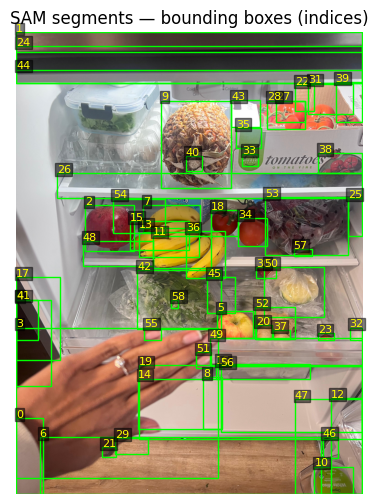

In [5]:
try:
    from segment_anything import sam_model_registry, SamAutomaticMaskGenerator
except Exception:
    # Install SAM if not present
    !pip -q install git+https://github.com/facebookresearch/segment-anything.git opencv-python
    from segment_anything import sam_model_registry, SamAutomaticMaskGenerator

import numpy as np, cv2, torch, os, urllib.request
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# --- pick image & keep original colors for display ---
# We assume 'img' (BGR) is defined from the previous step.
if 'img' in globals():
    base_img = img                  # BGR for processing
    im_disp  = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # RGB for display
elif 'image_rgb' in globals():
    base_img = image_rgb[:, :, ::-1]  # if you had an RGB image, convert to BGR base
    im_disp  = image_rgb.copy()
else:
    raise ValueError("No image found. Expected 'img' (BGR) or 'image_rgb' (RGB).")

H0, W0 = base_img.shape[:2]

# --- model + checkpoint ---
MODEL = "vit_b"  # options: "vit_b", "vit_l", "vit_h"
CKPTS = {
    "vit_b": "https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth",
    "vit_l": "https://dl.fbaipublicfiles.com/segment_anything/sam_vit_l_0b3195.pth",
    "vit_h": "https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth",
}
CKPT = f"/content/sam_{MODEL}.pth"
if not os.path.exists(CKPT):
    print("⏬ Downloading SAM checkpoint:", CKPTS[MODEL])
    urllib.request.urlretrieve(CKPTS[MODEL], CKPT)

device = "cuda" if torch.cuda.is_available() else "cpu"
print("🖥️ SAM device:", device)

# --- prepare image for SAM (RGB) with optional downscale ---
proc_img = im_disp.copy()  # SAM expects RGB; im_disp is RGB
H, W = proc_img.shape[:2]
scale = 1.0
if device == "cpu" and max(H, W) > 1024:
    scale = 1024.0 / max(H, W)
    proc_img = cv2.resize(proc_img, (int(W * scale), int(H * scale)), interpolation=cv2.INTER_AREA)
    H, W = proc_img.shape[:2]
    print(f"🪫 CPU mode — downscaled from {W0}x{H0} to {W}x{H} for speed (scale={scale:.3f})")

# --- run SAM ---
sam = sam_model_registry[MODEL](checkpoint=CKPT).to(device)
min_area = int(0.05 * H * W)  # ignore tiny segments (< 5% of image)
gen = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=16 if device == "cpu" else 32,
    pred_iou_thresh=0.86,
    stability_score_thresh=0.92,
    min_mask_region_area=min_area,
)
masks_raw = gen.generate(proc_img)

# --- mask-IOU adaptive NMS ---
def mIoU(a, b):
    a, b = a > 0, b > 0
    inter = np.logical_and(a, b).sum()
    union = np.logical_or(a, b).sum() + 1e-6
    return float(inter / union)

def thr(f, lo=0.6, hi=0.95):
    f = float(np.clip(f, 0, 1))
    return lo + (hi - lo) * f

scores = np.array([float(m.get("predicted_iou", m.get("stability_score", 1.0))) for m in masks_raw])
areas  = np.array([int(m["area"]) for m in masks_raw])
order  = scores.argsort()[::-1]
keep   = []

while len(order):
    i = order[0]
    keep.append(i)
    if len(order) == 1:
        break
    rest = order[1:]
    survivors = []
    for j in rest:
        if mIoU(masks_raw[i]["segmentation"], masks_raw[j]["segmentation"]) < thr(max(areas[i], areas[j]) / (H * W)):
            survivors.append(j)
    order = np.array(survivors, dtype=int)

# --- rescale results back to original image size (if downscaled) ---
sam_results = []
sx = sy = (1.0 / scale) if scale != 1.0 else 1.0  # back to original im_disp size
for k, i in enumerate(keep):
    x, y, w, h = masks_raw[i]["bbox"]  # in proc_img coords

    # rescale bbox to original size
    x1 = int(round(x * sx));       y1 = int(round(y * sy))
    x2 = int(round((x + w) * sx)); y2 = int(round((y + h) * sy))

    # rescale mask
    mask_small = masks_raw[i]["segmentation"].astype(np.uint8) * 255
    if scale != 1.0:
        mask_full = cv2.resize(mask_small, (W0, H0), interpolation=cv2.INTER_NEAREST)
    else:
        mask_full = mask_small

    sam_results.append({
        "id": k,
        "bbox_xyxy": [x1, y1, x2, y2],
        "mask": (mask_full > 0).astype(np.uint8),
        "area": int((mask_full > 0).sum()),
        "score": scores[i],
    })

print(f"SAM kept {len(sam_results)} segments (from {len(masks_raw)}) at {W0}x{H0}")

# --- quick summary table (first 10) ---
print(f"SAM segments: {len(sam_results)}")
for i, r in enumerate(sam_results[:10]):
    x1, y1, x2, y2 = r["bbox_xyxy"]
    print(f"#{i:02d} bbox=({x1},{y1},{x2},{y2}) area={r['area']:,} score={r['score']:.3f}")
if len(sam_results) > 10:
    print(f"... {len(sam_results) - 10} more")

# --- visualize bounding boxes on the original-looking image ---
fig, ax = plt.subplots(figsize=(8, 6))
ax.imshow(im_disp)
for i, r in enumerate(sam_results):
    x1, y1, x2, y2 = r["bbox_xyxy"]
    rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1,
                             linewidth=1, edgecolor='lime', facecolor='none')
    ax.add_patch(rect)
    ax.text(x1, max(0, y1 - 4), f'{i}', color='yellow', fontsize=8,
            bbox=dict(facecolor='black', alpha=0.5, pad=1))
plt.title("SAM segments — bounding boxes (indices)")
plt.axis("off")
plt.show()

# --- optional: overlay a single mask's contour without recoloring ---
SHOW_MASK_INDEX = None  # set to an int < len(sam_results) to overlay a mask outline

if isinstance(SHOW_MASK_INDEX, int) and 0 <= SHOW_MASK_INDEX < len(sam_results):
    mask = sam_results[SHOW_MASK_INDEX]["mask"].astype(np.uint8) * 255
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    fig2, ax2 = plt.subplots(figsize=(6, 5))
    ax2.imshow(im_disp)
    for cnt in contours:
        xs = cnt[:, 0, 0]; ys = cnt[:, 0, 1]
        ax2.plot(xs, ys, linewidth=1.2)
    ax2.set_title(f"Mask outline for segment #{SHOW_MASK_INDEX}")
    ax2.axis("off")
    plt.show()


# 5) Gemini Prediction (Base Gemini via Vertex SDK, No Saving)

This step:

- Builds per-segment crops from `sam_results`.
- Reconstructs a minimal DataFrame (`df`) if missing.
- Constructs an **in-memory grid** of all crops for context.
- Calls **base Gemini** (e.g. `gemini-2.5-flash`) via the Vertex AI Python SDK for each segment:
  - Uses `PROMPT_STAGE1` with `{seg_id}` filled in.
  - Sends both the **crop image** and the **grid image** as inline image parts.
- Parses the JSON response:
  - `{"label": "<short lower-case grocery name>", "packaged": <true|false>}`
- On any parse error, falls back to:
  - `label_pred = "other"`
  - `packaged = None`
- Updates `df` in-memory with:
  - `label_pred`
  - `packaged`
  - `raw` text for debugging

No files are written; everything stays in memory.


In [ ]:
import io, json, base64, math, re
import numpy as np
import pandas as pd
import cv2
from PIL import Image

from vertexai.generative_models import GenerativeModel, Part

# ---------- prompts ----------
PROMPT_STAGE1 = """
This is a sub image of a larger refrigerator image where a food item is segmented.
Tell me what the food item is.

Notes:
- The segmented image has a black background.
- Parts of the food item may not be visible because they may be occluded by other food items.
- The item may also be covered partially in plastic or packaging.
- The second image attached shows all the segmented objects in the refrigerator image.
- This sub-image corresponds to segmented object number {seg_id}.

Also tell me if (answer yes or no) this is a commercially packaged item
with printed labels or branding on the container.

Return ONLY a single JSON object exactly like this:
{
  "label": "<short lower-case grocery name>",
  "packaged": <true|false>
}
""".strip()

PROMPT_STAGE2 = """
This is a sub image of a larger refrigerator image where a food item is segmented.
Tell me what the food item is.

Notes:
- The segmented image has a black background.
- Parts of the food item may not be visible because they may be occluded by other food items.
- The item may also be covered partially in plastic or packaging.

Also tell me if (answer yes or no) this is a commercially packaged item
with printed labels or branding on the container.

Return ONLY a single JSON object exactly like this:
{
  "label": "<short lower-case grocery name>",
  "packaged": <true|false>
}
""".strip()

# ---------- Preconditions ----------
# vertexai.init(...) must have been called in 2.1
try:
    GEN_MAX_TOKENS  # from your config cell
except NameError:
    GEN_MAX_TOKENS = 2048

# Base Gemini model
try:
    gemini_label_model
except NameError:
    gemini_label_model = GenerativeModel("gemini-2.5-flash")  # or "gemini-1.5-flash" if you prefer

# ---------- helpers ----------
def to_uint8_3ch_bgr(arr):
    if arr is None:
        return None
    a = arr
    if a.dtype == np.bool_:
        a = (a.astype(np.uint8) * 255)
    elif np.issubdtype(a.dtype, np.floating):
        a = np.clip(a, 0.0, 1.0)
        a = (a * 255.0 + 0.5).astype(np.uint8)
    elif a.dtype != np.uint8:
        a = np.clip(a, 0, 255).astype(np.uint8)
    if a.ndim == 2:
        a = np.stack([a, a, a], axis=-1)
    elif a.ndim == 3 and a.shape[2] == 1:
        a = np.repeat(a, 3, axis=2)
    elif a.ndim == 3 and a.shape[2] >= 4:
        a = a[:, :, :3]
    return a

def bgr_to_rgb(a):
    return cv2.cvtColor(a, cv2.COLOR_BGR2RGB)

def jpg_bytes(array_rgb, quality=95):
    pil_img = Image.fromarray(array_rgb)
    buf = io.BytesIO()
    pil_img.save(buf, format="JPEG", quality=quality, optimize=True)
    return buf.getvalue()

def b64_jpeg(array_rgb):
    return base64.b64encode(jpg_bytes(array_rgb)).decode("utf-8")  # not used by SDK, but kept for compatibility

def extract_json(text):
    # Try direct JSON, else find first {...} block
    try:
        return json.loads(text)
    except Exception:
        pass
    m = re.search(r"\{.*\}", text, flags=re.DOTALL)
    if m:
        return json.loads(m.group(0))
    raise ValueError("No valid JSON object found.")

def fill_seg_id(prompt_text, seg_id):
    # keep prompt EXACT; only replace the {seg_id} token
    return prompt_text.replace("{seg_id}", str(seg_id))

def build_grid_rgb_from_crops(crops_rgb, cols=3, cell_max=256, pad=6, bg=255):
    """
    Build a simple in-memory tiled RGB grid for context; no disk writes.
    crops_rgb: list of (seg_id, rgb_array)
    """
    if not crops_rgb:
        raise RuntimeError("No crops to grid.")
    rows = math.ceil(len(crops_rgb) / cols)
    # resize each tile to fit (max side = cell_max)
    tiles = []
    for seg_id, rgb in crops_rgb:
        h, w = rgb.shape[:2]
        s = min(cell_max / max(h, w), 1.0)
        if s != 1.0:
            rgb = cv2.resize(rgb, (int(w * s), int(h * s)), interpolation=cv2.INTER_AREA)
        tiles.append((seg_id, rgb))
    max_h = max(t.shape[0] for _, t in tiles)
    max_w = max(t.shape[1] for _, t in tiles)

    grid_h = rows * max_h + (rows + 1) * pad
    grid_w = cols * max_w + (cols + 1) * pad
    grid = np.full((grid_h, grid_w, 3), bg, np.uint8)

    k = 0
    for r in range(rows):
        for c in range(cols):
            if k >= len(tiles):
                break
            _, t = tiles[k]
            th, tw = t.shape[:2]
            y0 = r * max_h + (r + 1) * pad
            x0 = c * max_w + (c + 1) * pad
            grid[y0:y0 + th, x0:x0 + tw] = t
            k += 1
    return grid

# ---------- base image (BGR) ----------
if 'img' in globals() and isinstance(img, np.ndarray):
    base_bgr = img
elif 'base_img' in globals() and isinstance(base_img, np.ndarray):
    base_bgr = base_img
else:
    raise RuntimeError("No base image found. Expected 'img' (BGR) or 'base_img'.")

H0, W0 = base_bgr.shape[:2]

# ---------- recover crops_info if missing ----------
if 'crops_info' not in globals() or not isinstance(crops_info, list) or len(crops_info) == 0:
    if 'sam_results' not in globals() or not len(sam_results):
        raise RuntimeError("Need 'sam_results' to rebuild crops. Run the SAM step first.")
    rebuilt = []
    for r in sam_results:
        x1, y1, x2, y2 = map(int, r['bbox_xyxy'])
        x1 = max(0, min(W0 - 1, x1)); x2 = max(0, min(W0, x2))
        y1 = max(0, min(H0 - 1, y1)); y2 = max(0, min(H0, y2))
        crop = None if (x2 <= x1 or y2 <= y1) else base_bgr[y1:y2, x1:x2].copy()
        rebuilt.append({
            'id': int(r['id']),
            'bbox_xyxy': [x1, y1, x2, y2],
            'crop_bgr': crop,
            'label': r.get('label')
        })
    crops_info = rebuilt

# ---------- minimal df if missing ----------
if 'df' not in globals() or not isinstance(df, pd.DataFrame) or len(df) == 0:
    rows_min = []
    inches_per_px = None
    if 'INCHES_PER_PIXEL' in globals():
        try:
            inches_per_px = float(INCHES_PER_PIXEL)
        except Exception:
            inches_per_px = None
    for c in crops_info:
        seg_id = int(c['id'])
        x1, y1, x2, y2 = c.get('bbox_xyxy', [0, 0, 0, 0])
        w_px = max(0, int(x2 - x1)); h_px = max(0, int(y2 - y1))
        w_in = w_px * inches_per_px if inches_per_px else np.nan
        h_in = h_px * inches_per_px if inches_per_px else np.nan
        lbl = (c.get('label') or '').strip().lower() or 'unknown'
        rows_min.append({
            'index': seg_id,
            'label': lbl,
            'width_in': w_in,
            'height_in': h_in,
            'volume_in3': np.nan,
            'weight_lb': np.nan
        })
    df = pd.DataFrame(rows_min)

# ---------- choose items to send (include 'unknown'; exclude explicit 'other') ----------
def _is_other(x):
    return isinstance(x, str) and x.strip().lower() == 'other'

view_df = df[~df['label'].apply(_is_other)].copy().sort_values('index').reset_index(drop=True)
if view_df.empty:
    raise RuntimeError("No non-'other' items to send. Label some items or relax the filter.")

# ---------- build in-memory grid RGB for context (not saved) ----------
crops_rgb_for_grid = []
id2crop = {int(c['id']): c.get('crop_bgr') for c in crops_info}
for _, row in view_df.iterrows():
    seg_id = int(row['index'])
    bgr = to_uint8_3ch_bgr(id2crop.get(seg_id))
    if bgr is not None and bgr.size:
        crops_rgb_for_grid.append((seg_id, bgr_to_rgb(bgr)))
if not crops_rgb_for_grid:
    raise RuntimeError("No crops available to form a context grid.")
grid_rgb = build_grid_rgb_from_crops(crops_rgb_for_grid, cols=3, cell_max=256, pad=6)

# ---------- Gemini calls using your prompt (base Gemini) ----------
results = []
for _, row in view_df.iterrows():
    seg_id = int(row['index'])
    bgr = to_uint8_3ch_bgr(id2crop.get(seg_id))
    if bgr is None or not bgr.size:
        print(f"⚠️ seg {seg_id}: missing crop; skipping")
        continue
    crop_rgb = bgr_to_rgb(bgr)

    prompt_text = fill_seg_id(PROMPT_STAGE1, seg_id)  # only replace {seg_id}
    crop_part = Part.from_data(jpg_bytes(crop_rgb), mime_type="image/jpeg")
    grid_part = Part.from_data(jpg_bytes(grid_rgb),  mime_type="image/jpeg")

    try:
        resp = gemini_label_model.generate_content(
            [
                prompt_text,
                crop_part,
                grid_part,
            ],
            generation_config={"max_output_tokens": int(GEN_MAX_TOKENS)},
        )
        text = (
            resp.candidates[0].content.parts[0].text
            if resp.candidates
            and resp.candidates[0].content
            and resp.candidates[0].content.parts
            and resp.candidates[0].content.parts[0].text
            else ""
        )
    except Exception as e:
        print(f"❌ seg {seg_id}: Gemini call error → {e}")
        results.append({
            "index": seg_id,
            "label_pred": "other",
            "packaged": None,
            "raw": f"error: {e}",
        })
        continue

    try:
        parsed = extract_json(text)
        label_pred = (parsed.get("label") or "").strip().lower() or "other"
        packaged = parsed.get("packaged")
        if isinstance(packaged, str):
            packaged = packaged.strip().lower() in ("true", "yes", "y", "1")
        results.append({
            "index": seg_id,
            "label_pred": label_pred,
            "packaged": bool(packaged) if packaged is not None else None,
            "raw": text,
        })
        print(f"✅ seg {seg_id}: {parsed}")
    except Exception as e:
        # Fallback: never crash; mark as "other"
        print(f"⚠️ seg {seg_id}: parse error → {e}; falling back to label='other'")
        results.append({
            "index": seg_id,
            "label_pred": "other",
            "packaged": None,
            "raw": text,
        })

pred_df = pd.DataFrame(results)

# ---------- merge predictions back into df (in-memory only; no save here) ----------
if len(pred_df):
    df = df.merge(pred_df[['index','label_pred','packaged','raw']], on="index", how="left", suffixes=('', '_new'))
    for col in ['label_pred', 'packaged', 'raw']:
        if f"{col}_new" in df.columns:
            df[col] = df[f"{col}_new"]
            df.drop(columns=[f"{col}_new"], inplace=True, errors='ignore')
    print("✨ df updated with columns: ['label_pred', 'packaged', 'raw']")
else:
    print("No predictions to merge; check earlier logs.")


✅ seg 0: {'label': 'potato', 'packaged': False}
⚠️ seg 1: parse error → No valid JSON object found.; falling back to label='other'
✅ seg 2: {'label': 'pomegranate', 'packaged': False}
⚠️ seg 3: parse error → No valid JSON object found.; falling back to label='other'
⚠️ seg 4: parse error → No valid JSON object found.; falling back to label='other'
✅ seg 5: {'label': 'apple', 'packaged': False}
✅ seg 6: {'label': 'white miso', 'packaged': True}
✅ seg 7: {'label': 'banana', 'packaged': False}
⚠️ seg 8: parse error → No valid JSON object found.; falling back to label='other'
✅ seg 9: {'label': 'pineapple', 'packaged': False}
✅ seg 10: {'label': 'miso', 'packaged': True}
✅ seg 11: {'label': 'banana', 'packaged': False}
✅ seg 12: {'label': 'white miso', 'packaged': True}
✅ seg 13: {'label': 'banana', 'packaged': False}
✅ seg 14: {'label': 'hand', 'packaged': False}
✅ seg 15: {'label': 'banana', 'packaged': False}
✅ seg 16: {'label': 'ground meat', 'packaged': False}
✅ seg 17: {'label': 'min

# 6) Visualize & Save Crops + Predictions

This step:

- Uses `df` (with `label_pred`, `width_in`, `height_in`, `volume_in3`, `weight_lb`) and `crops_info`.
- Saves each crop as a clean RGB JPEG:
  - `/content/outputs/crops_rgb_clean/seg_{id}.jpg`
- Renders and saves a grid of all non-`other` items with:
  - Segment index
  - Predicted label
  - Size (width × height in inches)
  - Volume (in³) and weight (lb), if available:
  - `/content/outputs/crops_grid_pred.jpg`


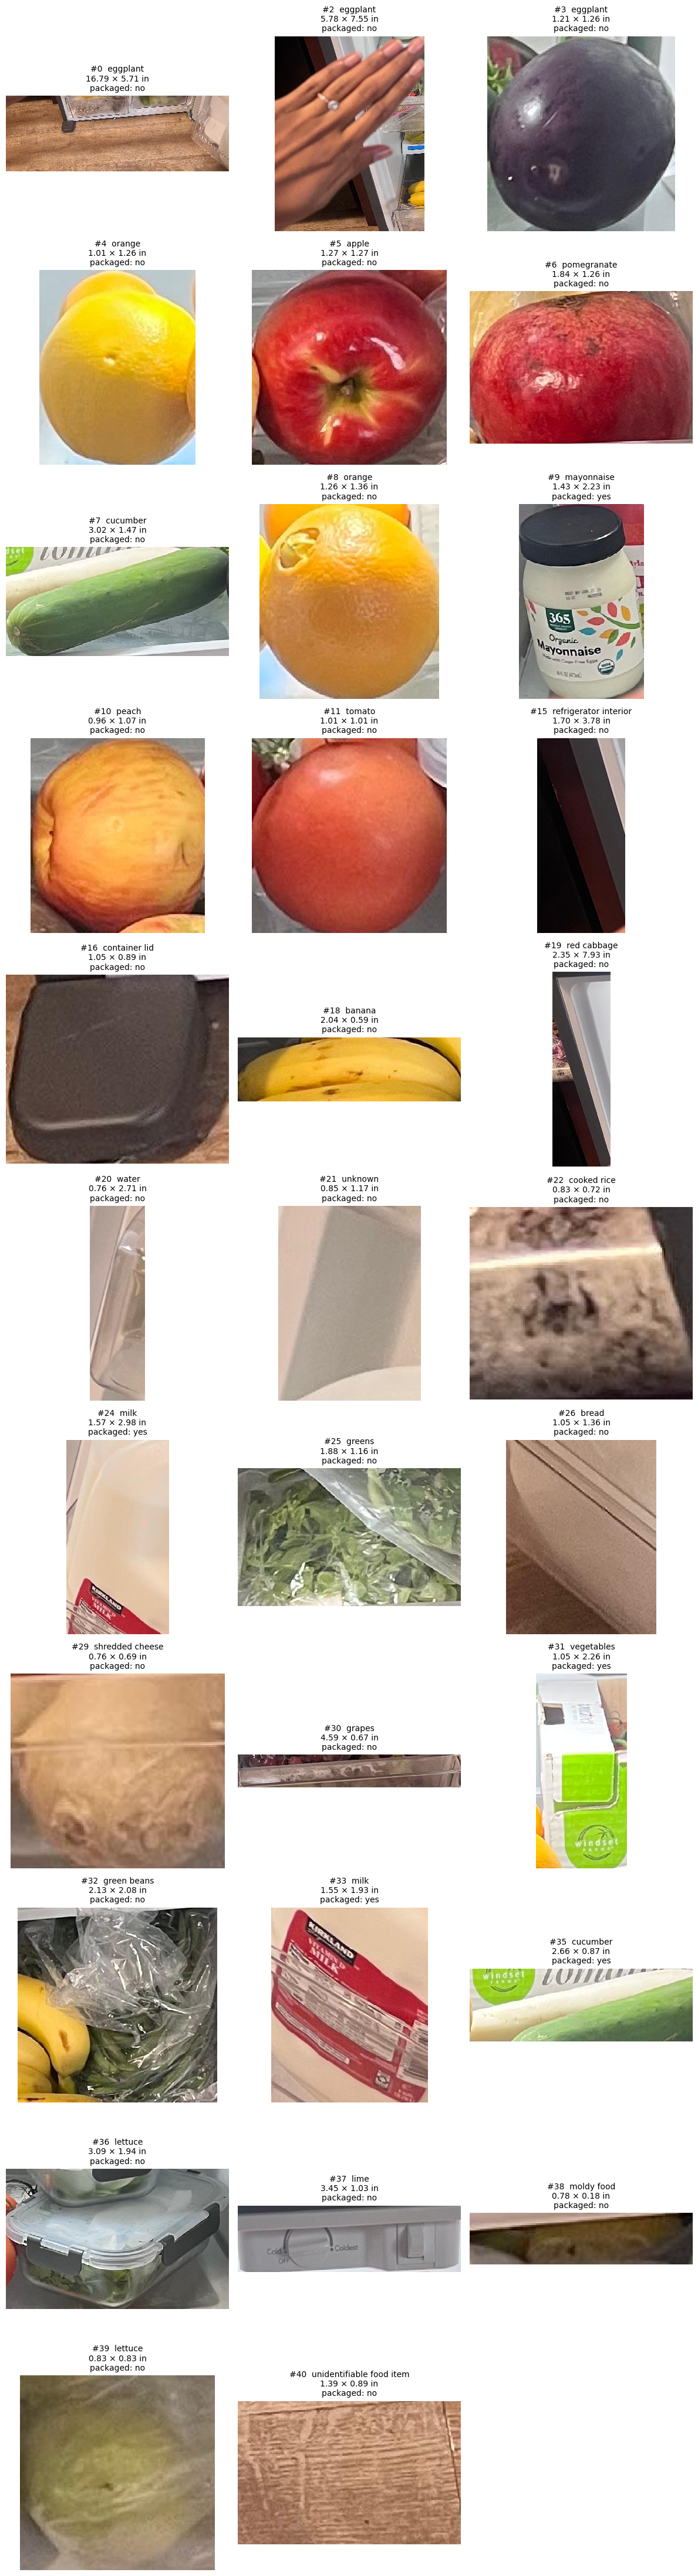

🧠 Saved predictions grid → /content/outputs/crops_grid_pred.jpg
📸 Saved per-crop RGB files → /content/outputs/crops_rgb_clean


In [ ]:
import os, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from PIL import Image

# ---------- helpers ----------
def to_uint8_3ch_bgr(arr):
    if arr is None:
        return None
    a = arr
    if a.dtype == np.bool_:
        a = (a.astype(np.uint8) * 255)
    elif np.issubdtype(a.dtype, np.floating):
        a = np.clip(a, 0.0, 1.0)
        a = (a * 255.0 + 0.5).astype(np.uint8)
    elif a.dtype != np.uint8:
        a = np.clip(a, 0, 255).astype(np.uint8)
    if a.ndim == 2:
        a = np.stack([a, a, a], axis=-1)
    elif a.ndim == 3 and a.shape[2] == 1:
        a = np.repeat(a, 3, axis=2)
    elif a.ndim == 3 and a.shape[2] >= 4:
        a = a[:, :, :3]
    return a

def _pick_label_from_row(row):
    """
    Prefer latest prediction columns if merges created label_pred_x / label_pred_y.
    Order:
      1) label_pred
      2) label_pred_y
      3) label_pred_x
      4) label (fallback)
    """
    for col in ["label_pred", "label_pred_y", "label_pred_x", "label"]:
        if col in row and isinstance(row[col], str) and row[col].strip():
            return row[col].strip().lower()
    return "unknown"

def _pick_packaged(row):
    for col in ["packaged", "packaged_y", "packaged_x"]:
        if col in row:
            val = row[col]
            if isinstance(val, bool):
                return val
            if isinstance(val, str) and val.strip().lower() in ("true","false"):
                return val.strip().lower() == "true"
    return None  # unknown

def title_for_row(row):
    # pick a label
    lbl = row.get("label_display", "unknown")
    if not isinstance(lbl, str) or not lbl.strip():
        lbl = "unknown"

    # pick sizes
    w = row.get("width_in", np.nan)
    h = row.get("height_in", np.nan)
    wtxt = f"{w:.2f}" if np.isfinite(w) else "?"
    htxt = f"{h:.2f}" if np.isfinite(h) else "?"

    # packaged yes/no
    pkg = _pick_packaged(row)
    if pkg is True:
        pkg_txt = "packaged: yes"
    elif pkg is False:
        pkg_txt = "packaged: no"
    else:
        pkg_txt = "packaged: ?"

    # final 3-line compact title
    return f"#{int(row['index'])}  {lbl}\n{wtxt} × {htxt} in\n{pkg_txt}"


# ---------- preconditions ----------
if 'df' not in globals() or not isinstance(df, pd.DataFrame) or len(df) == 0:
    raise RuntimeError("df missing. Run the Gemini prediction cell first.")
if 'crops_info' not in globals() or not isinstance(crops_info, list) or not len(crops_info):
    raise RuntimeError("crops_info missing. Run the SAM/cropping step first.")

os.makedirs("/content/outputs/crops_rgb_clean", exist_ok=True)
id2crop = {int(c['id']): c.get('crop_bgr') for c in crops_info}

# ---------- build display DataFrame ----------
df_display = df.copy()

# choose a display label per row
df_display["label_display"] = df_display.apply(_pick_label_from_row, axis=1)

# optional: drop "other" if you don't want them shown
show_df = df_display[df_display["label_display"].str.lower() != "other"].copy()
show_df = show_df.sort_values("index").reset_index(drop=True)

if show_df.empty:
    raise RuntimeError("No items to display (all are 'other' or missing labels).")

# ---------- render & save per-crop + predictions grid ----------
n = len(show_df)
cols = 3
rows = math.ceil(n / cols)
fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 4*rows))
axes = np.atleast_2d(axes)

missing = 0
for k, row in show_df.iterrows():
    seg_id = int(row["index"])
    ax = axes[k // cols, k % cols]
    crop_bgr = to_uint8_3ch_bgr(id2crop.get(seg_id))
    if crop_bgr is None or not crop_bgr.size:
        ax.text(0.5, 0.5, "(missing crop)", ha="center", va="center")
        ax.axis("off")
        missing += 1
        continue

    crop_rgb = cv2.cvtColor(crop_bgr, cv2.COLOR_BGR2RGB)
    ax.imshow(crop_rgb, interpolation="nearest")
    ax.set_title(title_for_row(row), fontsize=10)
    ax.axis("off")

    # save per-crop RGB
    out_path = f"/content/outputs/crops_rgb_clean/seg_{seg_id}.jpg"
    Image.fromarray(crop_rgb).save(out_path, format="JPEG", quality=95, optimize=True)

# hide unused axes
for k in range(n, rows * cols):
    axes.flatten()[k].axis("off")

plt.tight_layout()
pred_grid_path = "/content/outputs/crops_grid_pred.jpg"
plt.savefig(pred_grid_path, dpi=200, bbox_inches="tight")
plt.show()

print(f"🧠 Saved predictions grid → {pred_grid_path}")
print("📸 Saved per-crop RGB files → /content/outputs/crops_rgb_clean")
if missing:
    print(f"⚠️ {missing} crop(s) were missing and could not be shown.")


# 7) Estimate Volume & Weight for All Items

Now that you have:

- **Labels** from base Gemini (`label_pred` in `df`)
- **Physical sizes** from hand-as-scale (`width_in`, `height_in`)
- **Crops** for each detected segment (`crops_info`)

This section estimates **numeric volume and weight** for every item.  
Because packaged and unpackaged items contain different information, we use two different pipelines.


## 7.1 Packaged Items (`packaged == yes`): EasyOCR + Barcode + OpenFoodFacts

For items marked **packaged == yes**, we try to obtain the *actual* printed weight/volume from the package instead of estimating.

This step:

- Runs **EasyOCR** on each packaged crop to read visible printed text.
- Attempts **barcode detection** using `pyzbar`.
- If a barcode is found, queries the free **OpenFoodFacts API** for product metadata such as `"quantity": "453 g"` or `"16 fl oz"`.
- Parses all extracted text with regex to convert real units into:
  - `weight_lb` (from g, kg, oz, lb)
  - `volume_in3` (from ml, L, fl oz → cubic inches)

This step **does not use static rules**.  
If a crop contains no readable text/barcode, the final weight/volume is simply left as unknown.

Outputs:

- `final_predictions_pkg` → in-memory results  
- `/content/outputs/vertex_numeric_from_labels.csv`

Each row includes:

- `id` (segment index)
- `label`, `width_in`, `height_in`
- `volume_in3`, `weight_lb` (when found)
- `source` (e.g., `ocr_weight`, `api_volume`, `barcode:XXXXXX`, or `none`)
- `raw_pkg` (debug: OCR/API text)


In [ ]:
import os, math, re, json
import numpy as np
import pandas as pd
import cv2
from PIL import Image

import easyocr
from pyzbar.pyzbar import decode as decode_barcodes
import requests



# ----------------- Helpers -----------------

def _normalize_packaged_flag(v):
    """Turn df['packaged'] into a clean True/False flag."""
    if isinstance(v, bool):
        return v
    if isinstance(v, str):
        t = v.strip().lower()
        if t in ("true", "yes", "y", "1", "packaged"):
            return True
        if t in ("false", "no", "n", "0", "loose", "unpackaged"):
            return False
    return False


def _to_uint8_3ch_rgb(arr):
    if arr is None:
        return None
    a = arr
    if a.dtype == np.bool_:
        a = (a.astype(np.uint8) * 255)
    elif np.issubdtype(a.dtype, np.floating):
        a = np.clip(a, 0.0, 1.0)
        a = (a * 255.0 + 0.5).astype(np.uint8)
    elif a.dtype != np.uint8:
        a = np.clip(a, 0, 255).astype(np.uint8)
    if a.ndim == 2:
        a = np.stack([a, a, a], axis=-1)
    elif a.ndim == 3 and a.shape[2] == 1:
        a = np.repeat(a, 3, axis=2)
    elif a.ndim == 3 and a.shape[2] >= 4:
        a = a[:, :, :3]
    return a


def parse_weight_and_volume_from_text(text: str):
    """
    Parse net weight / volume from text.
    Returns (volume_in3, weight_lb) where either can be None.
    """
    text = (text or "").lower()
    volume_in3 = None
    weight_lb = None

    # --- Weight: lb, oz, g, kg ---
    # 1 lb = 1 lb
    m_lb = re.search(r'(\d+(\.\d+)?)\s*lb[s]?\b', text)
    if m_lb:
        try:
            weight_lb = float(m_lb.group(1))
        except Exception:
            pass

    # 1 oz = 1/16 lb
    if weight_lb is None:
        m_oz = re.search(r'(\d+(\.\d+)?)\s*oz\b', text)
        if m_oz and not re.search(r'fl\.?\s*oz\b', text):  # avoid confusing with fl oz
            try:
                oz = float(m_oz.group(1))
                weight_lb = oz / 16.0
            except Exception:
                pass

    # grams
    if weight_lb is None:
        m_g = re.search(r'(\d+(\.\d+)?)\s*g\b', text)
        if m_g:
            try:
                g = float(m_g.group(1))
                weight_lb = g / 453.592
            except Exception:
                pass

    # kg
    if weight_lb is None:
        m_kg = re.search(r'(\d+(\.\d+)?)\s*kg\b', text)
        if m_kg:
            try:
                kg = float(m_kg.group(1))
                weight_lb = kg * 2.20462
            except Exception:
                pass

    # --- Volume: ml, L, fl oz ---
    # 1 ml ≈ 0.0610237 in³
    # 1 L = 1000 ml
    # 1 fl oz ≈ 1.80469 in³
    m_ml = re.search(r'(\d+(\.\d+)?)\s*ml\b', text)
    m_l = re.search(r'(\d+(\.\d+)?)\s*l\b', text)
    m_fl_oz = re.search(r'(\d+(\.\d+)?)\s*fl\.?\s*oz\b', text)

    if m_ml:
        try:
            ml = float(m_ml.group(1))
            volume_in3 = ml * 0.0610237
        except Exception:
            pass
    elif m_l:
        try:
            liters = float(m_l.group(1))
            volume_in3 = liters * 1000.0 * 0.0610237
        except Exception:
            pass
    elif m_fl_oz:
        try:
            floz = float(m_fl_oz.group(1))
            volume_in3 = floz * 1.80469
        except Exception:
            pass

    return volume_in3, weight_lb


def run_easyocr_on_crop(crop_rgb, reader):
    """Return concatenated OCR text from EasyOCR for the crop."""
    try:
        results = reader.readtext(crop_rgb)
        # results: list of [ [x1,y1,x2,y2,...], text, confidence ]
        texts = [r[1] for r in results if len(r) >= 2]
        return " ".join(texts)
    except Exception as e:
        print(f"    OCR error: {e}")
        return ""


def decode_barcode_from_crop(crop_rgb_or_bgr):
    """Decode first barcode from crop using pyzbar; return code string or None."""
    try:
        # pyzbar works fine with RGB or BGR np arrays
        codes = decode_barcodes(crop_rgb_or_bgr)
        if not codes:
            return None
        # just take the first
        return codes[0].data.decode("utf-8")
    except Exception as e:
        print(f"    Barcode decode error: {e}")
        return None


def fetch_product_info_from_openfoodfacts(barcode):
    """
    Call OpenFoodFacts API for given barcode.
    Return a dict with keys 'quantity_text' and/or 'debug_raw' or None on failure.
    """
    if not barcode:
        return None

    url = f"https://world.openfoodfacts.org/api/v0/product/{barcode}.json"
    try:
        r = requests.get(url, timeout=4)
        if r.status_code != 200:
            return None
        data = r.json()
        if data.get("status") != 1:
            return None
        product = data.get("product", {}) or {}

        # 'quantity' is often like "453 g", "16 OZ", "1 L", etc.
        qty_text = product.get("quantity")

        # Some products also have 'product_quantity' + unit
        # e.g. product_quantity=453, product_quantity_unit="g"
        pq = product.get("product_quantity")
        pqu = product.get("product_quantity_unit")

        quantity_text = None
        if qty_text:
            quantity_text = str(qty_text)
        elif pq is not None and pqu:
            quantity_text = f"{pq} {pqu}"

        return {
            "quantity_text": quantity_text,
            "debug_raw": json.dumps(
                {
                    "quantity": product.get("quantity"),
                    "product_quantity": product.get("product_quantity"),
                    "product_quantity_unit": product.get("product_quantity_unit"),
                }
            )[:500],
        }
    except Exception as e:
        print(f"    OpenFoodFacts API error for {barcode}: {e}")
        return None


# ----------------- Preconditions -----------------

if "df" not in globals() or not isinstance(df, pd.DataFrame) or len(df) == 0:
    raise RuntimeError("df missing – run the base label prediction step first.")

if "crops_info" not in globals() or not isinstance(crops_info, list) or not len(crops_info):
    raise RuntimeError("crops_info missing – run the SAM/cropping step first.")

if "packaged" not in df.columns:
    raise RuntimeError("df has no 'packaged' column – rerun the base label step to populate it.")


# ----------------- Filter to packaged == yes -----------------

packaged_mask = df["packaged"].apply(_normalize_packaged_flag)
df_pkg = df[packaged_mask].copy().sort_values("index").reset_index(drop=True)

if df_pkg.empty:
    print("✅ No packaged==yes items found; skipping packaged weight/volume step.")
    final_predictions_pkg = []
else:
    print(f"📦 Found {len(df_pkg)} packaged items – estimating weight/volume via EasyOCR + barcode + OpenFoodFacts.")

    # build id -> crop mapping
    id2crop = {int(c["id"]): c for c in crops_info}

    # Initialize EasyOCR reader (English)
    reader = easyocr.Reader(['en'])

    results_pkg = []

    for k, row in df_pkg.iterrows():
        seg_id = int(row["index"])
        rec = id2crop.get(seg_id)

        if not rec:
            print(f"⚠️ seg {seg_id}: crop record missing; skipping.")
            continue

        crop_bgr = rec.get("crop_bgr")
        if crop_bgr is None or not isinstance(crop_bgr, np.ndarray) or not crop_bgr.size:
            print(f"⚠️ seg {seg_id}: crop_bgr empty; skipping.")
            continue

        # Convert BGR -> RGB for OCR; keep BGR for barcode if we want
        crop_rgb = cv2.cvtColor(_to_uint8_3ch_rgb(crop_bgr), cv2.COLOR_BGR2RGB)

        label_txt = row.get("label_pred") or row.get("label") or "unknown"
        w_in = float(row.get("width_in")) if "width_in" in row and pd.notna(row["width_in"]) else None
        h_in = float(row.get("height_in")) if "height_in" in row and pd.notna(row["height_in"]) else None

        source_parts = []
        volume_in3 = None
        weight_lb = None
        raw_text = ""

        print(f"[{k+1}/{len(df_pkg)}] seg {seg_id} - {label_txt}")

        # ---- 1) EasyOCR on crop ----
        ocr_text = run_easyocr_on_crop(crop_rgb, reader)
        raw_text += f"OCR: {ocr_text}\n"
        if ocr_text.strip():
            v1, w1 = parse_weight_and_volume_from_text(ocr_text)
            if v1 is not None:
                volume_in3 = v1
                source_parts.append("ocr_volume")
            if w1 is not None:
                weight_lb = w1
                source_parts.append("ocr_weight")

        # ---- 2) Barcode detection ----
        barcode = decode_barcode_from_crop(crop_rgb)
        if barcode:
            source_parts.append(f"barcode:{barcode}")
            api_info = fetch_product_info_from_openfoodfacts(barcode)
            if api_info:
                qt = api_info.get("quantity_text")
                dbg = api_info.get("debug_raw") or ""
                raw_text += f"API_qty: {qt}\nAPI_raw: {dbg}\n"
                if qt:
                    v2, w2 = parse_weight_and_volume_from_text(qt)
                    # Only overwrite if we don't already have values
                    if volume_in3 is None and v2 is not None:
                        volume_in3 = v2
                        source_parts.append("api_volume")
                    if weight_lb is None and w2 is not None:
                        weight_lb = w2
                        source_parts.append("api_weight")

        # summarise source
        source = ",".join(source_parts) if source_parts else "none"

        out = {
            "id": seg_id,
            "label": str(label_txt),
            "width_in": w_in,
            "height_in": h_in,
            "source": source,
            "barcode": barcode if barcode else None,
            "raw_pkg": raw_text[:500],
        }
        if volume_in3 is not None:
            out["volume_in3"] = volume_in3
        if weight_lb is not None:
            out["weight_lb"] = weight_lb

        results_pkg.append(out)

        print(
            f"    → src={source:<25} "
            f"V={volume_in3 if volume_in3 is not None else '?'} in³, "
            f"W={weight_lb if weight_lb is not None else '?'} lb"
        )

    final_predictions_pkg = results_pkg
    os.makedirs("/content/outputs", exist_ok=True)
    csv_pkg = "/content/outputs/vertex_numeric_from_labels.csv"
    pd.DataFrame(results_pkg).to_csv(csv_pkg, index=False)
    print(f"💾 Saved packaged-item numeric predictions → {csv_pkg}")


📦 Found 5 packaged items – estimating weight/volume via EasyOCR + barcode + OpenFoodFacts.
Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.0% Complete[1/5] seg 9 - mayonnaise
    → src=none                      V=? in³, W=? lb
[2/5] seg 24 - milk
    → src=none                      V=? in³, W=? lb
[3/5] seg 31 - vegetables
    → src=none                      V=? in³, W=? lb
[4/5] seg 33 - milk
    → src=none                      V=? in³, W=? lb
[5/5] seg 35 - cucumber
    → src=none                      V=? in³, W=? lb
💾 Saved packaged-item numeric predictions → /content/outputs/vertex_numeric_from_labels.csv


## 7.2 Unpackaged Items (`packaged == no`): Tuned Gemini (`:generateContent`)

Items that are **not packaged**—such as produce, loose food, bowls, containers—lack printed weight/volume, so we use your **tuned Gemini model** to estimate numeric values.

This step:

- Filters to `packaged == no`
- Skips invalid/noisy labels (e.g., `"other"`)
- Sends each crop (image + size) to your **tuned Gemini endpoint** using REST `generateContent`
- Uses function-calling (`set_values`) as the primary structured output
- Falls back to JSON/text parsing when needed

Outputs:

- `final_predictions_vertex` → in-memory results
- `/content/outputs/vertex_numeric_predictions.csv`

---

Both packaged (7.1) and unpackaged (7.2) numeric results are merged in **Step 9.1**, giving `df` the best available `volume_in3` and `weight_lb` for every detected item.


In [ ]:
# ============================
# 7.2) Tuned GEMINI for UNPACKAGED items (packaged == no)
# ============================

import os, io, json, base64, time, re, random, math, concurrent.futures
import numpy as np, cv2
from PIL import Image
import pandas as pd

# ---------- Prereqs ----------
try:
    SESSION, URL_TUNED
except NameError:
    raise RuntimeError("Missing SESSION/URL_TUNED. Run your Vertex config cells first.")
URL_GENERATE = URL_TUNED  # tuned endpoint :generateContent

if 'df' not in globals() or 'crops_info' not in globals():
    raise RuntimeError("Need df and crops_info before calling tuned Gemini.")


# ---------- Small helper for packaged flag ----------
def _normalize_packaged_flag(v):
    if isinstance(v, bool):
        return v
    if isinstance(v, str):
        t = v.strip().lower()
        if t in ("true","yes","y","1","packaged"):
            return True
        if t in ("false","no","n","0","unpackaged","loose"):
            return False
    return False


# ---------- Tunables ----------
BATCH_SIZE         = 12
CONCURRENCY        = 5
IMAGE_MAIN_SIDE    = 224
IMAGE_FB_SIDE      = 192
JPEG_QUALITY       = 80
TOKENS_MAIN        = 4096
TOKENS_FB          = 256
REQ_TIMEOUT_S      = 45
ITEM_TIMEOUT_S     = 70
MAX_ATTEMPTS       = 4
SUBMIT_GAP_S       = 0.02


# ---------- Image Helpers ----------
def _to_uint8_3ch_rgb(arr):
    if arr is None:
        return None
    a = arr
    if a.dtype == np.bool_:
        a = (a.astype(np.uint8) * 255)
    elif np.issubdtype(a.dtype, np.floating):
        a = (np.clip(a, 0.0, 1.0) * 255.0 + 0.5).astype(np.uint8)
    elif a.dtype != np.uint8:
        a = np.clip(a, 0, 255).astype(np.uint8)
    if a.ndim == 2:
        a = np.stack([a, a, a], -1)
    elif a.ndim == 3 and a.shape[2] == 1:
        a = np.repeat(a, 3, axis=2)
    elif a.ndim == 3 and a.shape[2] >= 4:
        a = a[:, :, :3]
    return a


def _ensure_crop_rgb_from_record(rec):
    if "crop_rgb" in rec and isinstance(rec["crop_rgb"], np.ndarray):
        return _to_uint8_3ch_rgb(rec["crop_rgb"])
    if "crop_bgr" in rec and isinstance(rec["crop_bgr"], np.ndarray):
        return cv2.cvtColor(_to_uint8_3ch_rgb(rec["crop_bgr"]), cv2.COLOR_BGR2RGB)
    raise KeyError("record has no crop_rgb/crop_bgr")


def _sizes_in_inches(rec):
    if rec.get("w_cm") is not None and rec.get("h_cm") is not None:
        return float(rec["w_cm"]) / 2.54, float(rec["h_cm"]) / 2.54
    return float(rec.get("w_px",0)) / 96.0, float(rec.get("h_px",0)) / 96.0


def _b64_from_rgb(arr_rgb, max_side=224, q=80):
    h, w = arr_rgb.shape[:2]
    s = min(1.0, float(max_side) / float(max(h, w)))
    if s < 1.0:
        arr_rgb = cv2.resize(arr_rgb, (int(w*s), int(h*s)), interpolation=cv2.INTER_AREA)
    buf = io.BytesIO()
    Image.fromarray(arr_rgb).save(buf, format="JPEG", quality=q, optimize=True)
    return base64.b64encode(buf.getvalue()).decode("utf-8")


# ---------- Function Calling Declaration ----------
TOOL_DECL = {
    "function_declarations": [{
        "name": "set_values",
        "description": "Return numeric estimates for volume (in^3) and weight (lb).",
        "parameters": {
            "type": "object",
            "properties": {
                "volume_in3": {"type": "number"},
                "weight_lb":  {"type": "number"}
            },
            "required": ["volume_in3", "weight_lb"]
        }
    }]
}

def make_body(img_b64, label, width_in, height_in, max_tokens):
    return {
        "system_instruction": {
            "role": "system",
            "parts": [{
                "text": (
                    "Call the function set_values with two numeric arguments: "
                    "volume_in3 (cubic inches) and weight_lb (pounds). "
                    "Do not respond with natural language or code blocks."
                )
            }]
        },
        "contents": [{
            "role": "user",
            "parts": [
                {"inline_data": {"mime_type": "image/jpeg", "data": img_b64}},
                {"text": f'label="{label}", width_in={width_in:.3f}, height_in={height_in:.3f}.'}
            ]
        }],
        "generation_config": {
            "temperature": 0.0,
            "max_output_tokens": int(max_tokens),
        },
        "tool_config": {
            "function_calling_config": {
                "mode": "ANY",
                "allowed_function_names": ["set_values"]
            }
        },
        "tools": [TOOL_DECL],
    }


# ---------- Parsing Helpers ----------
_number = r'[-+]?(?:\d+(?:\.\d+)?|\.\d+)(?:[eE][-+]?\d+)?'

def _extract_numbers_from_text(text):
    if not isinstance(text, str) or not text.strip():
        return None
    vol = re.search(r'volume_in3"\s*:\s*(' + _number + ')', text) or \
          re.search(r'volume_in3\s*[:=]\s*(' + _number + ')', text)
    wt  = re.search(r'weight_lb"\s*:\s*(' + _number + ')', text) or \
          re.search(r'weight_lb\s*[:=]\s*(' + _number + ')', text)
    if vol and wt:
        try:
            return {"volume_in3": float(vol.group(1)), "weight_lb": float(wt.group(1))}
        except Exception:
            return None
    nums = re.findall(_number, text)
    if len(nums) >= 2:
        try:
            return {"volume_in3": float(nums[0]), "weight_lb": float(nums[1])}
        except Exception:
            return None
    return None


def _extract_first_json(text):
    if not isinstance(text, str) or not text:
        return None
    fence = re.search(r"```(?:json)?\s*(.*?)```", text, re.DOTALL | re.IGNORECASE)
    if fence:
        inner = fence.group(1).strip()
        try:
            return json.loads(inner)
        except Exception:
            text = inner
    i, n = 0, len(text)
    while i < n:
        if text[i] == '{':
            depth = 0
            j = i
            in_str = False
            esc = False
            while j < n:
                ch = text[j]
                if in_str:
                    if esc: esc = False
                    elif ch == '\\': esc = True
                    elif ch == '"': in_str = False
                else:
                    if ch == '"': in_str = True
                    elif ch == '{': depth += 1
                    elif ch == '}':
                        depth -= 1
                        if depth == 0:
                            cand = text[i:j+1]
                            try:
                                return json.loads(cand)
                            except Exception:
                                break
                j += 1
        i += 1
    return None


def _normalize_obj(obj):
    if not isinstance(obj, dict):
        return None
    try:
        return {
            "volume_in3": float(obj["volume_in3"]),
            "weight_lb":  float(obj["weight_lb"])
        }
    except Exception:
        return None


def _parse_any(js):
    try:
        cands = js.get("candidates") or []
        if not cands:
            return None, None
        c0 = cands[0]
        finish = c0.get("finishReason")
        parts = (c0.get("content") or {}).get("parts") or []

        # 1) function call
        for p in parts:
            if isinstance(p, dict) and "functionCall" in p:
                fc = p["functionCall"]
                args = fc.get("args")
                if isinstance(args, str):
                    try: args = json.loads(args)
                    except: return None, finish
                norm = _normalize_obj(args)
                if norm: return norm, finish

        # 2) direct JSON
        for p in parts:
            if not isinstance(p, dict): continue
            txt = p.get("text")
            if not isinstance(txt, str): continue
            txt = txt.strip()
            if not txt: continue

            try:
                obj = json.loads(txt)
                norm = _normalize_obj(obj)
                if norm: return norm, finish
            except: pass

            obj2 = _extract_first_json(txt)
            norm = _normalize_obj(obj2)
            if norm: return norm, finish

            if finish == "STOP":
                obj3 = _extract_numbers_from_text(txt)
                if obj3: return obj3, finish

        return None, finish
    except Exception:
        return None, None


# ---------- Worker ----------
def _infer_one(rec):
    seg_id = rec.get("id", 0)
    label  = rec.get("label", "unknown")
    w_in, h_in = _sizes_in_inches(rec)
    t0 = time.time()

    try:
        rgb = _ensure_crop_rgb_from_record(rec)
    except Exception as e:
        return seg_id, label, {"raw": f"no-crop: {e}"}

    b64_main  = _b64_from_rgb(rgb, max_side=IMAGE_MAIN_SIDE, q=JPEG_QUALITY)
    b64_small = _b64_from_rgb(rgb, max_side=IMAGE_FB_SIDE,  q=max(60, JPEG_QUALITY-5))

    attempts_cfg = [
        ("main1",  b64_main,  TOKENS_MAIN),
        ("small1", b64_small, TOKENS_FB),
        ("main2",  b64_main,  TOKENS_MAIN),
        ("small2", b64_small, TOKENS_FB),
    ][:MAX_ATTEMPTS]

    last_finish = None

    for i, (tag, b64img, toks) in enumerate(attempts_cfg, 1):
        if time.time() - t0 > ITEM_TIMEOUT_S:
            return seg_id, label, {"raw": f"item timeout (last finish={last_finish})"}

        body = make_body(b64img, label, w_in, h_in, toks)

        try:
            r = SESSION.post(URL_GENERATE, json=body, timeout=REQ_TIMEOUT_S)
        except Exception as e:
            last_finish = f"network-error: {e}"
            time.sleep(0.15 * i)
            continue

        if r.status_code in (429, 503):
            last_finish = f"HTTP {r.status_code}"
            time.sleep(0.3 * i)
            continue

        if r.status_code != 200:
            return seg_id, label, {"raw": f"HTTP {r.status_code}: {r.text[:300]}"}

        parsed, finish = _parse_any(r.json())
        last_finish = finish

        if parsed:
            return seg_id, label, parsed

        time.sleep(0.15 * i)

    return seg_id, label, {"raw": f"no structured output (finish={last_finish})"}


def _heartbeat(msg):
    print(msg, flush=True)


# =========================================================
#                 🔥 BUILD WORKLIST (UPDATED)
# =========================================================

id2crop_full = {int(c['id']): c for c in crops_info}
rows = []

for _, r in df.iterrows():
    # ----------------------------
    # 1) EXCLUDE packaged == yes
    # ----------------------------
    is_pkg = _normalize_packaged_flag(r.get("packaged"))
    if is_pkg:    # <-- packaged items go to step 7.1 NOT here
        continue

    # ----------------------------
    # 2) EXCLUDE label == "other"
    # ----------------------------
    raw_pred = r.get("label_pred")
    lbl = (str(raw_pred if (isinstance(raw_pred, str) and raw_pred.strip())
               else r.get("label","unknown")) or "unknown").strip().lower()
    if lbl == "other":
        continue

    seg_id = int(r["index"])
    c = id2crop_full.get(seg_id)
    if not c:
        continue

    x1, y1, x2, y2 = c.get("bbox_xyxy",[0,0,0,0])
    rows.append({
        "id": seg_id,
        "label": lbl,
        "w_px": max(0, int(x2-x1)),
        "h_px": max(0, int(y2-y1)),
        "crop_bgr": c.get("crop_bgr"),
    })


work = rows
N = len(work)
if N == 0:
    raise RuntimeError("No unpackaged items to send to tuned Gemini (packaged==yes are handled in 7.1).")


_heartbeat(
    f"Parallel sending {N} UNPACKAGED crops to Vertex :generateContent "
    f"(batches={BATCH_SIZE}, workers={CONCURRENCY}, tokens={TOKENS_MAIN}, img={IMAGE_MAIN_SIDE}px)."
)


# =========================================================
#                     🔥 RUN BATCHES
# =========================================================

final_predictions_vertex = []
global_start = time.time()
done_total = 0

for batch_start in range(0, N, BATCH_SIZE):
    batch = work[batch_start: batch_start + BATCH_SIZE]
    _heartbeat(f"\n— Batch {batch_start//BATCH_SIZE + 1} — items {batch_start+1}..{batch_start+len(batch)}")

    with concurrent.futures.ThreadPoolExecutor(max_workers=CONCURRENCY) as ex:
        futures = []
        for rec in batch:
            futures.append(ex.submit(_infer_one, rec))
            time.sleep(SUBMIT_GAP_S)

        for fut in concurrent.futures.as_completed(futures):
            try:
                seg_id, label, res = fut.result()
            except Exception as e:
                seg_id, label, res = -1, "unknown", {"raw": f"exception: {e}"}

            rec = next((x for x in batch if x.get("id") == seg_id), None)
            w_in, h_in = _sizes_in_inches(rec) if rec else (0.0, 0.0)

            out = {
                "id": seg_id,
                "label": label,
                "width_in": round(w_in, 3),
                "height_in": round(h_in, 3),
            }

            if isinstance(res, dict) and \
               "volume_in3" in res and \
               "weight_lb"  in res:
                out["volume_in3"] = float(res["volume_in3"])
                out["weight_lb"]  = float(res["weight_lb"])
                done_total += 1
                print(
                    f"[{done_total}/{N}] #{seg_id:<3} {label:<18} "
                    f"{out['width_in']:>6.2f}×{out['height_in']:<6.2f} in → "
                    f"{out['volume_in3']:>8.2f} in³, {out['weight_lb']:>6.3f} lb",
                    flush=True,
                )
            else:
                raw = res.get("raw", str(res)[:200])
                out["raw"] = raw
                done_total += 1
                print(
                    f"[{done_total}/{N}] #{seg_id:<3} {label:<18} "
                    f"{out['width_in']:>6.2f}×{out['height_in']:<6.2f} in → RAW: {raw}",
                    flush=True,
                )

            final_predictions_vertex.append(out)


elapsed = time.time() - global_start

print("\n----------------------------------------------------------------", flush=True)
print(
    f"Done. {len(final_predictions_vertex)} UNPACKAGED crops in {elapsed:.1f}s  "
    f"(batches={math.ceil(N/BATCH_SIZE)}, concurrency={CONCURRENCY}).",
    flush=True,
)

# ---------- Save CSV ----------
os.makedirs("/content/outputs", exist_ok=True)
out_csv = "/content/outputs/vertex_numeric_predictions.csv"
pd.DataFrame(final_predictions_vertex).to_csv(out_csv, index=False)
print(f"💾 Saved → {out_csv}", flush=True)


Parallel sending 27 UNPACKAGED crops to Vertex :generateContent (batches=12, workers=5, tokens=4096, img=224px).

— Batch 1 — items 1..12
[1/27] #0   eggplant            30.76×10.46  in →    17.00 in³,  0.600 lb
[2/27] #2   eggplant            10.58×13.82  in →    67.30 in³,  0.900 lb
[3/27] #5   apple                2.33×2.33   in →     6.65 in³,  0.200 lb
[4/27] #3   eggplant             2.22×2.30   in →     6.06 in³,  0.201 lb
[5/27] #8   orange               2.30×2.50   in →    12.14 in³,  0.421 lb
[6/27] #6   pomegranate          3.37×2.30   in →    13.64 in³,  0.510 lb
[7/27] #7   cucumber             5.53×2.70   in →    31.61 in³,  1.096 lb
[8/27] #16  container lid        1.93×1.64   in →     0.47 in³,  0.017 lb
[9/27] #11  tomato               1.84×1.84   in →     3.27 in³,  0.250 lb
[10/27] #4   orange               1.84×2.30   in →     4.10 in³,  0.142 lb
[11/27] #15  refrigerator interior   3.12×6.93   in → 31104.00 in³, 40.000 lb
[12/27] #10  peach                1.76×1.97

# 9) Per-Segment Crop Preview (Readable Labels & Numbers)

This cell shows each segmented item as its **own thumbnail** with a text title above it:

`#id  label — W×H in — V=in³ — W=lb`

It uses:
- `crops_info` for the actual crop image
- `df` for `label_pred` (or `label`) and numeric fields


## 9.1 - Merge tuned volume/weight values into df (must run before display)

In [ ]:
# ============================
# 9.1 Merge Packaged + Unpackaged Numerics into df
# ============================

import pandas as pd
import os
import numpy as np

if 'df' not in globals():
    raise RuntimeError("df missing – run label prediction first.")

os.makedirs("/content/outputs", exist_ok=True)

# =====================================================
# 1) Load PACKAGED numeric predictions (OCR + barcode)
# =====================================================

df_pkg = None
csv_pkg = "/content/outputs/vertex_numeric_from_labels.csv"

if 'final_predictions_pkg' in globals() and len(final_predictions_pkg):
    print("Using in-memory packaged (OCR) predictions.")
    df_pkg = pd.DataFrame(final_predictions_pkg)
elif os.path.exists(csv_pkg):
    print(f"Loaded packaged predictions from {csv_pkg}")
    df_pkg = pd.read_csv(csv_pkg)

# Clean packaged DF
if df_pkg is not None and not df_pkg.empty:
    # Keep all possibly useful fields
    keep_pkg = [c for c in df_pkg.columns
                if c in ['id', 'label', 'width_in', 'height_in',
                         'volume_in3', 'weight_lb', 'source', 'barcode', 'raw_pkg']]
    df_pkg = df_pkg[keep_pkg].rename(columns={'id': 'index'})
else:
    print("⚠️ No packaged predictions found.")
    df_pkg = pd.DataFrame([])


# =====================================================
# 2) Load UNPACKAGED numeric predictions (tuned Gemini)
# =====================================================

df_vert = None
csv_vert = "/content/outputs/vertex_numeric_predictions.csv"

if 'final_predictions_vertex' in globals() and len(final_predictions_vertex):
    print("Using in-memory unpackaged (Gemini) predictions.")
    df_vert = pd.DataFrame(final_predictions_vertex)
elif os.path.exists(csv_vert):
    print(f"Loaded unpackaged predictions from {csv_vert}")
    df_vert = pd.read_csv(csv_vert)

# Clean unpackaged DF
if df_vert is not None and not df_vert.empty:
    keep_vert = [c for c in df_vert.columns
                 if c in ['id', 'label', 'width_in', 'height_in',
                          'volume_in3', 'weight_lb', 'raw']]
    df_vert = df_vert[keep_vert].rename(columns={'id': 'index'})
else:
    print("⚠️ No unpackaged predictions found.")
    df_vert = pd.DataFrame([])


# =====================================================
# 3) Combine packaged + unpackaged numeric predictions
# =====================================================

df_num = pd.concat([df_pkg, df_vert], ignore_index=True)
df_num = df_num.drop_duplicates(subset=['index'], keep='first')  # packaged first

print(f"\nCombined numeric preds: {len(df_num)} items\n")

# =====================================================
# 4) Merge into main df
# =====================================================

df = df.merge(df_num, on="index", how="left", suffixes=("", "_num"))

# Prefer merged numeric values if present
for col in ["volume_in3", "weight_lb", "width_in", "height_in"]:
    if f"{col}_num" in df.columns:
        df[col] = df[col].where(df[col].notna(), df[f"{col}_num"])
        df.drop(columns=[f"{col}_num"], inplace=True, errors="ignore")

# Keep `source`, `barcode`, `raw_pkg` if added
# They will remain in df automatically from merge.

# =====================================================
# 5) Display sanity check
# =====================================================

print("Merged numeric fields:\n")
cols_show = [c for c in [
    "index", "label_pred", "packaged",
    "width_in", "height_in",
    "volume_in3", "weight_lb",
    "source", "barcode"
] if c in df.columns]

display(df[cols_show].head(20))


Using in-memory packaged (OCR) predictions.
Using in-memory unpackaged (Gemini) predictions.

Combined numeric preds: 32 items

Merged numeric fields:



index             label_pred packaged   width_in  height_in  volume_in3  \
0       0               eggplant    False  16.791130   5.708870     17.0000   
1       1                  other     None  17.149356   2.934041         NaN   
2       2               eggplant    False   5.777104   7.545489     67.3000   
3       3               eggplant    False   1.211145   1.256634      6.0554   
4       4                 orange    False   1.006444   1.256634      4.1000   
5       5                  apple    False   1.273692   1.273692      6.6500   
6       6            pomegranate    False   1.836619   1.256634     13.6400   
7       7               cucumber    False   3.019333   1.472707     31.6100   
8       8                 orange    False   1.256634   1.364670     12.1400   
9       9             mayonnaise     True   1.432904   2.234647         NaN   
10     10                  peach    False   0.960955   1.074678      3.1900   
11     11                 tomato    False   1.006444   1.006444      3.2700   
12     12                  other     None   4.702426   1.990144         NaN   
13     13                  other     None   1.120167   3.087566         NaN   
14     14                  other     None   0.312737   0.227445         NaN   
15     15  refrigerator interior    False   1.700152   3.781274  31104.0000   
16     16          container lid    False   1.051933   0.892722      0.4730   
17     17                  other     None   1.546626   4.793404         NaN   
18     18                 banana    False   2.035633   0.585671      6.8000   
19     19            red cabbage    False   2.348370   7.926459    140.8400   

    weight_lb source barcode  
0      0.6000    NaN     NaN  
1         NaN    NaN     NaN  
2      0.9000    NaN     NaN  
3      0.2011    NaN     NaN  
4      0.1420    NaN     NaN  
5      0.2000    NaN     NaN  
6      0.5100    NaN     NaN  
7      1.0960    NaN     NaN  
8      0.4210    NaN     NaN  
9         NaN   none    None  
10     0.0900    NaN     NaN  
11     0.2500    NaN     NaN  
12        NaN    NaN     NaN  
13        NaN    NaN     NaN  
14        NaN    NaN     NaN  
15    40.0000    NaN     NaN  
16     0.0170    NaN     NaN  
17        NaN    NaN     NaN  
18     0.4200    NaN     NaN  
19     4.6800    NaN     NaN

## 9.2 - Per-Segment Crop Preview with Titles (V & W included)

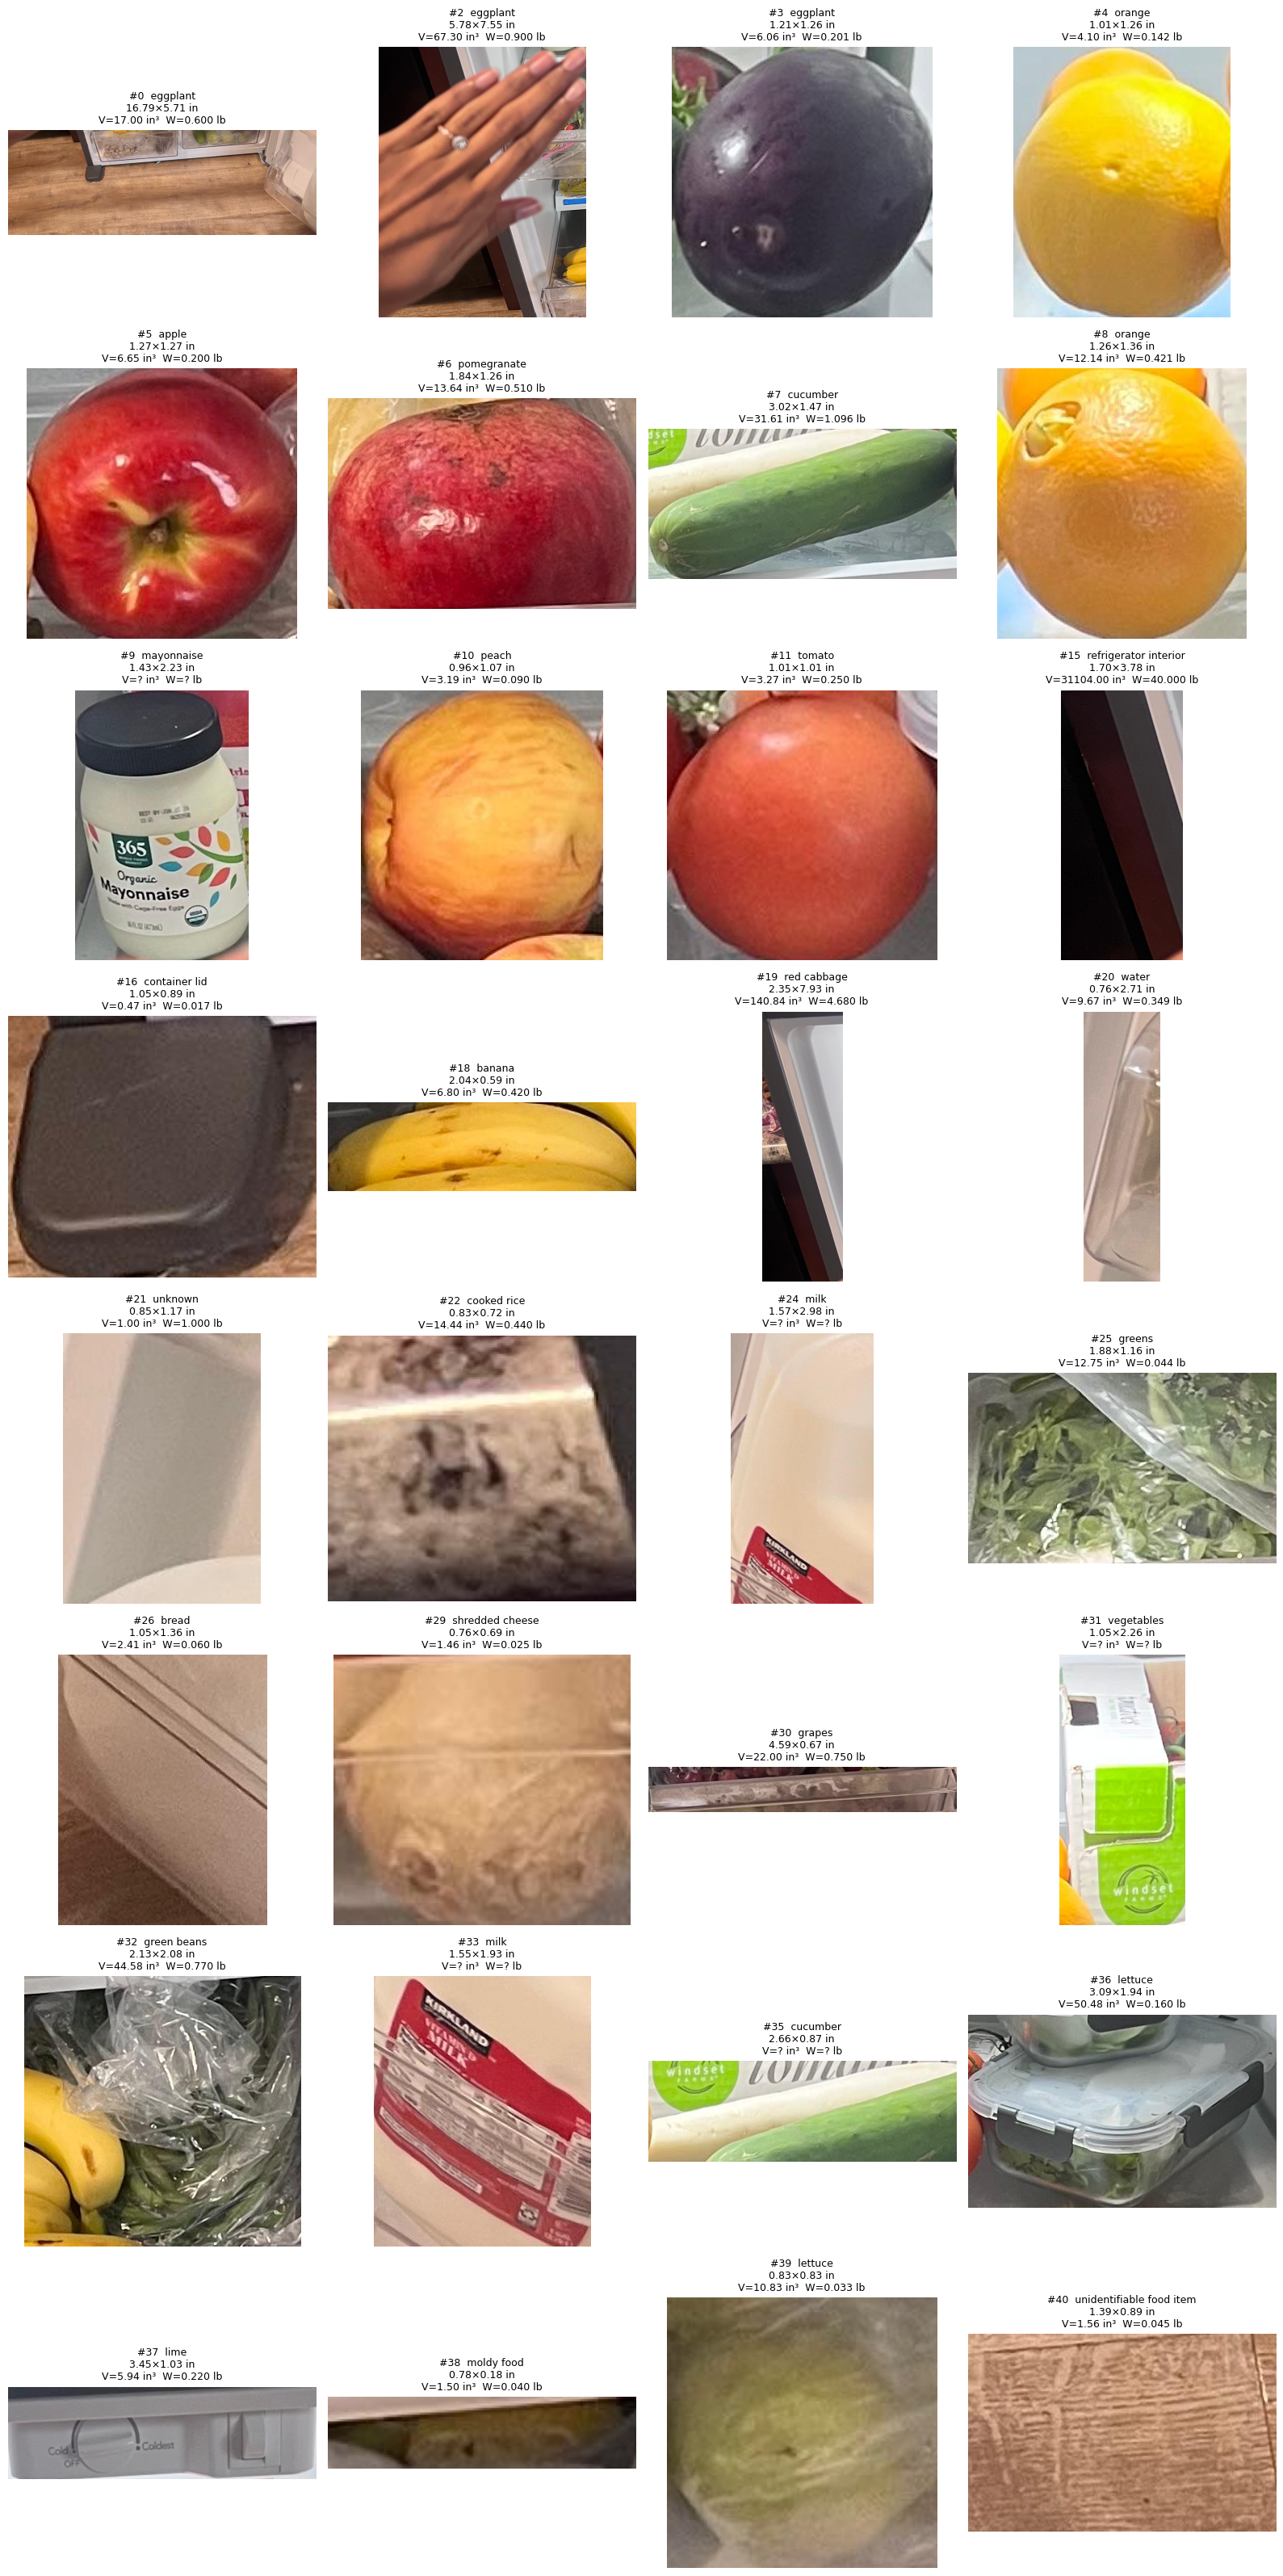

In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt
import cv2

# ---------- Preconditions ----------
if 'df' not in globals() or df.empty:
    raise RuntimeError("df missing. Run merge numeric cell first.")
if 'crops_info' not in globals() or not len(crops_info):
    raise RuntimeError("crops_info missing. Run SAM step first.")

def _to_uint8_3ch_bgr(arr):
    if arr is None:
        return None
    a = arr
    if a.dtype == np.bool_:
        a = (a.astype(np.uint8) * 255)
    elif np.issubdtype(a.dtype, np.floating):
        a = (np.clip(a, 0, 1) * 255).astype(np.uint8)
    elif a.dtype != np.uint8:
        a = np.clip(a,0,255).astype(np.uint8)
    if a.ndim == 2:
        a = np.stack([a,a,a],-1)
    elif a.ndim==3 and a.shape[2]==1:
        a = np.repeat(a,3,axis=2)
    elif a.ndim==3 and a.shape[2]>=4:
        a = a[:,:,:3]
    return a

def _pick_label(row):
    for col in ["label_pred","label_pred_y","label_pred_x","label_display","label"]:
        if col in row and isinstance(row[col],str) and row[col].strip():
            return row[col].strip().lower()
    return "unknown"

def _fmt(v, nd=2):
    try:
        v = float(v)
        if not np.isfinite(v):
            return "?"
        return f"{v:.{nd}f}"
    except:
        return "?"

def _title_for_row(row):
    seg = int(row["index"])
    lbl = _pick_label(row)
    w = _fmt(row.get("width_in"))
    h = _fmt(row.get("height_in"))
    vol = _fmt(row.get("volume_in3"))
    wt = _fmt(row.get("weight_lb"), 3)
    return f"#{seg}  {lbl}\n{w}×{h} in\nV={vol} in³  W={wt} lb"

id2crop = {int(c["id"]): c.get("crop_bgr") for c in crops_info}

def _is_other(x):
    return isinstance(x,str) and x.strip().lower()=="other"

# ---------- FIXED LINE (THIS IS THE IMPORTANT UPDATE) ----------
show_df = df[df.apply(lambda r: not _is_other(_pick_label(r)), axis=1)].sort_values("index").reset_index(drop=True)

# -------------------------------------

n=len(show_df)
cols=4
rows=math.ceil(n/cols)

fig,axes=plt.subplots(rows,cols,figsize=(4*cols,4*rows))
axes=np.atleast_2d(axes)

for k,row in show_df.iterrows():
    ax=axes[k//cols,k%cols]
    seg=int(row["index"])
    crop=_to_uint8_3ch_bgr(id2crop.get(seg))
    if crop is None or not isinstance(crop, np.ndarray) or crop.size == 0:
        ax.text(0.5,0.5,"(missing)",ha="center",va="center")
        ax.axis("off")
        continue
    crop=cv2.cvtColor(crop,cv2.COLOR_BGR2RGB)
    ax.imshow(crop)
    ax.set_title(_title_for_row(row),fontsize=9)
    ax.axis("off")

for k in range(n,rows*cols):
    axes.flatten()[k].axis("off")

plt.tight_layout()
plt.show()


# 10) Recipe Suggestions from Gemini (Top 5 with Nutrition)

Now that we have per-item **labels, volumes, and weights**, we’ll:

1. Build a structured **inventory** from `df`:
   - Only keep “real” food items (skip `other`, `unknown`, etc.).
   - For each item we pass:  
     `name`, `weight_lb`, `weight_g`, `volume_in3`.

2. Send this inventory to **Gemini** (Vertex `gemini-2.5-flash`) and ask for:
   - **Top 5 recipe ideas** that use these ingredients (plus pantry basics).
   - For each recipe:
     - Title and short description  
     - Number of servings  
     - Ingredients table with quantities (using the available amounts)  
     - Step-by-step instructions  
     - Simple per-serving nutrition table (kcal / protein / carbs / fat)

3. Render Gemini’s response directly as **Markdown**, so the recipes show up as
   clean sections with tables inside the notebook.

> Note: All weights are approximate (based on the tuned numeric model); Gemini is allowed to round to friendly kitchen values.


In [ ]:
import json
import numpy as np
import pandas as pd
from IPython.display import Markdown, display
from vertexai.generative_models import GenerativeModel

# ---------- Preconditions ----------
if "df" not in globals() or df.empty:
    raise RuntimeError("df is missing or empty. Run the earlier steps first.")

BAD_LABELS = {"other", "unknown", "unidentifiable", "empty", "no food item"}

# ---------- Build compact inventory summary ----------
inv_rows = []
for _, row in df.iterrows():
    name = str(row.get("label_pred") or row.get("label") or "").strip().lower()
    if not name or name in BAD_LABELS:
        continue

    vol = row.get("volume_in3")
    wt = row.get("weight_lb")

    has_wt = isinstance(wt, (int, float, np.floating)) and np.isfinite(wt)
    has_vol = isinstance(vol, (int, float, np.floating)) and np.isfinite(vol)

    if not (has_wt or has_vol):
        continue

    wt_lb = float(wt) if has_wt else None
    vol_in3 = float(vol) if has_vol else None

    inv_rows.append(
        {
            "name": name,
            "weight_lb": wt_lb,
            "volume_in3": vol_in3,
        }
    )

if not inv_rows:
    raise RuntimeError("No usable items found in df (weights/volumes missing).")

inv_df = pd.DataFrame(inv_rows)
agg = (
    inv_df.groupby("name", as_index=False)
    .agg({"weight_lb": "sum", "volume_in3": "sum"})
    .round({"weight_lb": 3, "volume_in3": 1})
)

# Short text summary instead of huge JSON (to avoid token/safety issues)
lines = []
for _, r in agg.head(25).iterrows():  # cap to keep prompt small
    w = r["weight_lb"]
    v = r["volume_in3"]
    parts = [r["name"]]
    if isinstance(w, (int, float)) and np.isfinite(w) and w > 0:
        parts.append(f"~{w:.2f} lb")
    if isinstance(v, (int, float)) and np.isfinite(v) and v > 0:
        parts.append(f"~{v:.0f} in³")
    lines.append(" - " + ", ".join(parts))

inventory_summary = "Inventory (approx):\n" + "\n".join(lines)

print("📦 Inventory summary sent to Gemini:")
print(inventory_summary)

# ---------- Model ----------
model = GenerativeModel("gemini-2.5-flash")

# Cache for the 5 recipes we fetch once
_recipes_cache = None


def _collect_text_from_response(resp) -> str:
    """Safely collect text from a non-streaming response."""
    if resp is None:
        return ""
    text = getattr(resp, "text", "") or ""
    if text:
        return text

    parts_out = []
    candidates = getattr(resp, "candidates", None) or []
    for cand in candidates:
        content = getattr(cand, "content", None)
        if content and getattr(content, "parts", None):
            for p in content.parts:
                if hasattr(p, "text") and p.text:
                    parts_out.append(p.text)
    return "".join(parts_out)


def _parse_recipes_json(raw: str):
    """Extract and parse JSON array of recipes from the model text."""
    if not raw:
        return []

    start = raw.find("[")
    end = raw.rfind("]")
    if start != -1 and end != -1 and end > start:
        raw = raw[start : end + 1]

    try:
        data = json.loads(raw)
        if isinstance(data, list):
            return data
        if isinstance(data, dict):
            if "recipes" in data and isinstance(data["recipes"], list):
                return data["recipes"]
    except Exception:
        return []

    return []


def _fetch_all_recipes_once():
    """Call Gemini ONCE to get 5 recipes as JSON and store in _recipes_cache."""
    global _recipes_cache

    if _recipes_cache is not None:
        return

    json_schema = """
[
  {
    "title": "string",
    "servings": "string or number",
    "total_time_minutes": "number or string like '45'",
    "active_time_minutes": "number or string, optional",
    "ingredients": [
      {
        "item": "string",
        "quantity": "string"
      }
    ],
    "instructions": [
      "Step-by-step instruction sentence."
    ],
    "nutrition_per_serving": {
      "calories": "number or string",
      "protein_g": "number or string",
      "carbs_g": "number or string",
      "fat_g": "number or string"
    }
  }
]
""".strip()

    prompt = f"""
You are an expert home cook and nutritionist.

{inventory_summary}

Create EXACTLY 5 different recipes using ONLY these foods as the main ingredients
(plus small amounts of oil, salt, pepper, garlic, onion, herbs,
spices, vinegar, soy sauce, stock).

Return ONLY a valid JSON array of 5 recipe objects.
No explanations, no markdown, no comments.
Must follow the schema:

{json_schema}
""".strip()

    raw_text = ""
    try:
        resp = model.generate_content(
            prompt,
            generation_config={
                "temperature": 0.55,
                "max_output_tokens": None,   # <<< UNLIMITED TOKENS
            },
            stream=False,
        )
        raw_text = _collect_text_from_response(resp).strip()
    except Exception:
        raw_text = ""

    recipes = _parse_recipes_json(raw_text)
    if not isinstance(recipes, list):
        recipes = []

    _recipes_cache = recipes


def _render_markdown_from_recipe(recipe: dict, recipe_number: int) -> str:
    """Render one recipe dict into the notebook markdown format."""
    if not isinstance(recipe, dict):
        return ""

    title = str(recipe.get("title") or f"Recipe {recipe_number}").strip()

    servings = recipe.get("servings", "")
    total_time = recipe.get("total_time_minutes") or recipe.get("total_time") or ""
    active_time = recipe.get("active_time_minutes") or recipe.get("active_time") or ""

    def _fmt_time(t):
        if not t:
            return "N/A"
        try:
            val = float(t)
            if val.is_integer():
                val = int(val)
            return f"{val} minutes"
        except:
            return str(t)

    ingredients = recipe.get("ingredients", [])
    instructions = recipe.get("instructions", [])
    nutrition = recipe.get("nutrition_per_serving", {})

    ing_lines = []
    for ing in ingredients:
        if isinstance(ing, dict):
            item = str(ing.get("item") or "").strip()
            qty = str(ing.get("quantity") or "").strip()
            if item and qty:
                ing_lines.append(f"- {item} — {qty}")
            elif item:
                ing_lines.append(f"- {item}")
        else:
            ing_lines.append(f"- {str(ing)}")

    instr_lines = [f"{i+1}. {str(step)}" for i, step in enumerate(instructions)]

    md_parts = [
        f"# Recipe {recipe_number}: {title}",
        f"**Servings:** {servings}  ",
        f"**Total Time:** {_fmt_time(total_time)}  ",
        f"**Active Cook Time:** {_fmt_time(active_time)}  ",
        "",
        "### Ingredients",
        *ing_lines,
        "",
        "### Instructions",
        *instr_lines,
        "",
        "### Nutrition (per serving)",
        f"- calories: {nutrition.get('calories', 'N/A')}",
        f"- protein (g): {nutrition.get('protein_g', 'N/A')}",
        f"- carbs (g): {nutrition.get('carbs_g', 'N/A')}",
        f"- fat (g): {nutrition.get('fat_g', 'N/A')}",
    ]

    return "\n".join(md_parts)


def generate_recipe_stream(recipe_number: int) -> str:
    _fetch_all_recipes_once()

    if not _recipes_cache:
        return ""

    idx = recipe_number - 1
    if idx < 0 or idx >= len(_recipes_cache):
        return ""

    return _render_markdown_from_recipe(_recipes_cache[idx], recipe_number)


# ---------- Generate & display 5 recipes ----------
for i in range(1, 6):
    print(f"\n================= Recipe {i} =================\n")
    md = generate_recipe_stream(i)
    if not md:
        print(f"⚠️ Recipe {i} came back empty or was blocked.")
    else:
        display(Markdown(md))
    print("\n" + "-" * 80 + "\n")


📦 Inventory summary sent to Gemini:
Inventory (approx):
 - apple, ~0.20 lb, ~7 in³
 - banana, ~0.42 lb, ~7 in³
 - bread, ~0.06 lb, ~2 in³
 - container lid, ~0.02 lb, ~0 in³
 - cooked rice, ~0.44 lb, ~14 in³
 - cucumber, ~1.10 lb, ~32 in³
 - eggplant, ~1.70 lb, ~90 in³
 - grapes, ~0.75 lb, ~22 in³
 - green beans, ~0.77 lb, ~45 in³
 - greens, ~0.04 lb, ~13 in³
 - lettuce, ~0.19 lb, ~61 in³
 - lime, ~0.22 lb, ~6 in³
 - moldy food, ~0.04 lb, ~2 in³
 - orange, ~0.56 lb, ~16 in³
 - peach, ~0.09 lb, ~3 in³
 - pomegranate, ~0.51 lb, ~14 in³
 - red cabbage, ~4.68 lb, ~141 in³
 - refrigerator interior, ~40.00 lb, ~31104 in³
 - shredded cheese, ~0.03 lb, ~2 in³
 - tomato, ~0.25 lb, ~3 in³
 - unidentifiable food item, ~0.04 lb, ~2 in³
 - water, ~0.35 lb, ~10 in³

================= Recipe 1 =================



# Recipe 1: Eggplant & Green Bean Stir-fry with Rice
**Servings:** 2  
**Total Time:** 30 minutes  
**Active Cook Time:** 20 minutes  

### Ingredients
- eggplant — 1.70 lb (about 1 large)
- green beans — 0.77 lb (about 3.5 cups)
- cooked rice — 0.44 lb (about 1.5 cups)
- oil — 2 tbsp
- garlic — 2 cloves, minced
- onion — 1/2 medium, sliced
- soy sauce — 2 tbsp
- salt — to taste
- pepper — to taste

### Instructions
1. Cut eggplant into 1-inch cubes. Trim green beans.
2. Heat oil in a large skillet or wok over medium-high heat.
3. Add garlic and onion, cook until fragrant, about 1 minute.
4. Add eggplant and green beans, stir-fry for 8-10 minutes until vegetables are tender-crisp.
5. Stir in soy sauce, salt, and pepper.
6. Serve hot over cooked rice.

### Nutrition (per serving)
- calories: 280
- protein (g): 12
- carbs (g): 64
- fat (g): 1


--------------------------------------------------------------------------------


================= Recipe 2 =================



# Recipe 2: Vibrant Red Cabbage & Orange Slaw
**Servings:** 4  
**Total Time:** 20 minutes  
**Active Cook Time:** 15 minutes  

### Ingredients
- red cabbage — 2.0 lb (about 1/2 large head)
- apple — 0.20 lb (about 1 small)
- orange — 0.56 lb (about 1 large)
- lime — 0.22 lb (about 1-2 limes)
- oil — 3 tbsp
- vinegar — 1 tbsp
- salt — 1/2 tsp
- pepper — 1/4 tsp

### Instructions
1. Thinly slice or shred the red cabbage. Core and thinly slice the apple.
2. Peel and segment the orange, removing any pith.
3. In a large bowl, combine the shredded cabbage, sliced apple, and orange segments.
4. In a small bowl, whisk together the juice of the lime, oil, vinegar, salt, and pepper to make the dressing.
5. Pour the dressing over the slaw and toss gently to combine.
6. Let sit for 5-10 minutes before serving to allow flavors to meld.

### Nutrition (per serving)
- calories: 100
- protein (g): 3
- carbs (g): 24
- fat (g): 1


--------------------------------------------------------------------------------


================= Recipe 3 =================



# Recipe 3: Fresh Cucumber, Tomato & Lettuce Salad with Cheese
**Servings:** 2  
**Total Time:** 10 minutes  
**Active Cook Time:** 10 minutes  

### Ingredients
- cucumber — 1.10 lb (about 1 large)
- tomato — 0.25 lb (about 1 medium)
- lettuce — 0.19 lb (about 2-3 cups chopped)
- shredded cheese — 0.03 lb (about 2 tbsp)
- oil — 2 tbsp
- vinegar — 1 tbsp
- salt — to taste
- pepper — to taste

### Instructions
1. Dice the cucumber and tomato into bite-sized pieces.
2. Wash and chop the lettuce.
3. In a medium bowl, combine cucumber, tomato, and lettuce.
4. Sprinkle shredded cheese over the vegetables.
5. In a small bowl, whisk together oil, vinegar, salt, and pepper.
6. Drizzle the dressing over the salad and toss gently before serving.

### Nutrition (per serving)
- calories: 80
- protein (g): 4
- carbs (g): 12
- fat (g): 3


--------------------------------------------------------------------------------


================= Recipe 4 =================



# Recipe 4: Sweet Pomegranate & Grape Fruit Medley
**Servings:** 2  
**Total Time:** 10 minutes  
**Active Cook Time:** 10 minutes  

### Ingredients
- grapes — 0.75 lb (about 2 cups)
- pomegranate — 0.51 lb (about 1 medium)
- banana — 0.42 lb (about 1 medium)
- peach — 0.09 lb (about 1 small)

### Instructions
1. Wash grapes and remove from stems. Halve larger grapes if desired.
2. Carefully remove seeds from the pomegranate.
3. Peel and slice the banana.
4. Pit and dice the peach.
5. Gently combine all fruits in a serving bowl.
6. Serve chilled.

### Nutrition (per serving)
- calories: 290
- protein (g): 4
- carbs (g): 75
- fat (g): 2


--------------------------------------------------------------------------------


================= Recipe 5 =================



# Recipe 5: Braised Red Cabbage with Toasted Bread Crumbs
**Servings:** 4  
**Total Time:** 45 minutes  
**Active Cook Time:** 20 minutes  

### Ingredients
- red cabbage — 2.68 lb (about 1 large head)
- bread — 0.06 lb (about 1 slice)
- greens — 0.04 lb (about 1 cup)
- oil — 2 tbsp
- onion — 1 medium, sliced
- garlic — 2 cloves, minced
- vinegar — 2 tbsp (e.g., apple cider or red wine)
- water — 1/2 cup
- salt — to taste
- pepper — to taste
- herbs — 1 tsp (e.g., dried thyme or bay leaf)

### Instructions
1. Thinly slice the red cabbage. Chop the bread into small cubes for crumbs.
2. Heat 1 tablespoon of oil in a large pot or Dutch oven over medium heat. Add onion and cook until softened, about 5 minutes.
3. Add garlic and cook for another minute until fragrant.
4. Add sliced red cabbage, vinegar, water, salt, pepper, and herbs. Stir well to combine.
5. Bring to a simmer, then reduce heat to low, cover, and cook for 30-35 minutes, stirring occasionally, until cabbage is tender.
6. While cabbage cooks, heat remaining 1 tablespoon of oil in a small skillet. Add bread cubes and toast until golden brown and crispy, forming bread crumbs.
7. Stir in the greens into the braised cabbage during the last 5 minutes of cooking.
8. Serve the braised red cabbage topped with toasted bread crumbs.

### Nutrition (per serving)
- calories: 95
- protein (g): 4
- carbs (g): 21
- fat (g): 1


--------------------------------------------------------------------------------

